# Peroxidase reaction with PGHS data analysis

In [6]:
library(ggplot2)

In [7]:
ggplotRegression <- function (fit) {

require(ggplot2)

ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red") +
  labs(title = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                     "Intercept =",signif(fit$coef[[1]],5 ),
                     " Slope =",signif(fit$coef[[2]], 5),
                     " P =",signif(summary(fit)$coef[2,4], 5)))
}

In [51]:
allPlotter <- function (dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN = FALSE,
                        support_start = 0, support_end = 0,
                       IGNORE_NON_ENZ = FALSE) {
    require(ggplot2)
        #whole raw reaction plot
    whole_PLOT <- ggplot(dot_data, aes(V1,V2)) + geom_point() +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 30)) +
                ggtitle("Whole plot")

#       support plot, for tricky situations
    if(support_start != support_end){
        support_data <- subset(dot_data, V1 > support_start & V1 < support_end)
        support_PLOT <- ggplot(support_data, aes(V1,V2)) + geom_point() +
#         scale_x_continuous(breaks = scales::pretty_breaks(n = 30)) +
        ggtitle("Support plot")
    } else {
        support_PLOT <- NULL
    }    
    
    if(IGNORE_NON_ENZ == FALSE){
#linear approximation of non-enzymatic part of reaction
    
        non_enz_fit_part <- subset(dot_data, V1 > linear_start & V1 < enzyme_start) #choose exact time of boundaries
        nEnz_start = non_enz_fit_part$V1[which(abs(non_enz_fit_part$V1 - linear_start)
                                ==min(abs(non_enz_fit_part$V1 - linear_start)))]
        nEnz_end = non_enz_fit_part$V1[which(abs(non_enz_fit_part$V1 - enzyme_start)
                                ==min(abs(non_enz_fit_part$V1 - enzyme_start)))]

        fit <- lm(V2~V1, data = non_enz_fit_part)
        non_enz_regression_PLOT <- ggplotRegression(fit)
        slope = fit$coefficients[[2]]


    
#whole plot with non-enzymatic reaction substracted from it
        dot_data_norm <- dot_data
        dot_data_norm$V2 <- dot_data$V2 - dot_data$V1 * slope
        whole_normalized_PLOT <- ggplot(dot_data_norm, aes(V1,V2)) + geom_point() +
            scale_x_continuous(breaks = scales::pretty_breaks(n = 30)) +
            ggtitle("Whole plot normalized")
    }else{
        message("No nonezymatic part found! Ignoring normalization.")
        whole_normalized_PLOT <- NULL
        non_enz_regression_PLOT <- NULL
        dot_data_norm <- dot_data
        nEnz_start <- NULL
        nEnz_end <- NULL
    }

    
    #Find exact time of enzyme reaction start
    true_enz_start = enzyme_start + start_linear
    enz_part <- subset(dot_data_norm, V1 > (true_enz_start))
    true_enz_start = enz_part$V1[which(abs(enz_part$V1 - true_enz_start)
                        ==min(abs(enz_part$V1 - true_enz_start)))]
    
    Enz_start =  true_enz_start
    
#enzymatic reaction part of the experiment (normalized and inverted)


    react_start_absorbtion = dot_data_norm$V2[which(abs(dot_data_norm$V1-true_enz_start)
                            ==min(abs(dot_data_norm$V1-true_enz_start)))] #find index of the element closest to enzyme_start
    dot_data_exp <- subset(dot_data_norm, V1 >= true_enz_start)
    dot_data_exp$V2 <- (dot_data_exp$V2 - react_start_absorbtion ) / 13500 * 1000000
    dot_data_exp$V1 <- dot_data_exp$V1 - true_enz_start
    enzymatic_react_PLOT <- ggplot(dot_data_exp, aes(V1,V2)) + geom_point() +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 30)) +
                ggtitle("Enzymatic part of the reaction")
    
    if(dot_data_exp$V1[[1]] != 0 | dot_data_exp$V2[[1]] != 0) stop(
    "ERROR: PLOTs are not zeroed! after normalization")
#Enzymatic part of the data output============================================
    Enz_data_part <- dot_data_exp
    

#=============================================================================
     dot_data_exp_start <- subset(dot_data_exp,V1 < end_exp)

#      dot_data_exp_start$V1 <- dot_data_exp_start$V1 - dot_data_exp_start$V1[[1]] #make data start at 0,0
#      dot_data_exp_start$V2 <- dot_data_exp_start$V2 - dot_data_exp_start$V2[[1]] #make data start at 0,0
    dot_data_exp_start_OUT <- dot_data_exp_start
    
    #Linear approximation of enzymatic reaction rate
    fit <- lm(V2~V1, data = dot_data_exp_start, subset = ( V1 < end_linear))
    approx_linear_PLOT <- ggplotRegression(fit)
    approx_linear_slope = fit$coefficients[[2]]
    
    if (STUBBORN == TRUE) {
        message("SUBBORN ACTIVATED :)")
        #Exponential approximation of enzymatic reaction rate
        if(dot_data_exp_start$V1[[1]] != 0 | dot_data_exp_start$V2[[1]] != 0) stop(
        "ERROR: PLOTs are not zeroed! one exp")
        fit_exp <- nls(V2 ~ P_inf * (1-exp(-V1/tau)),
                        data = dot_data_exp_start, start = c(P_inf = 25, tau = 11), 
                        algorithm ="port",
                        control = list(maxiter = 5000, minFactor=1/2000, warnOnly=T))
        output_exp <- coef(fit_exp)
        output_exp["v0"] <- output_exp["P_inf"]/output_exp["tau"]

        exp_coefs <- list(coef(fit_exp))

        approx_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
        stat_smooth(method = "nls",
                    formula = y ~ P_inf * (1-exp(-x/tau)),
                    method.args = exp_coefs, se = F, colour = "red", na.rm=TRUE) +
        ggtitle(paste("One exponent approx V0 = ", round(output_exp["v0"], digits = 2)))


        #Double exponent approximation of enzymatic reaction rate
        dot_data_exp_start <- subset(dot_data_exp, V1 < end_double_exp)

        if(dot_data_exp_start$V1[[1]] != 0 | dot_data_exp_start$V2[[1]] != 0) stop(
        "ERROR: PLOTs are not zeroed! two exp")

        fit_exp <- nls(
            V2 ~ y0 + A1 * (1 - exp( -V1/t1)) + A2 * (1 - exp( -V1/t2)),
            data = dot_data_exp_start, start = c(y0 = 0, A1 = 10, t1 = 5, A2 = 20, t2 = 47), 
            algorithm ="port", control = list(maxiter = 5000, minFactor=1/2000, warnOnly=T))
        

        output_doub_exp <- coef(fit_exp)
        output_doub_exp["v0"] <- output_doub_exp["A1"]/output_doub_exp["t1"] + output_doub_exp["A2"]/output_doub_exp["t2"]

        exp_coefs <- list(coef(fit_exp))

        dot_data_exp_start$pred_nls <- predict(fit_exp)
        approx_double_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
            geom_line(aes(x = V1,y = pred_nls), colour = "red", size=1.5) +
            ggtitle(paste("Double exponent approx V0 = ",
                          round(output_doub_exp["v0"], digits = 2)))    
        
        
        exponentials_out <- list(approx_exp_PLOT = approx_exp_PLOT,
                approx_double_exp_PLOT = approx_double_exp_PLOT,
                output_exp = output_exp,
                output_doub_exp = output_doub_exp)
    } else {
    
        exponentials_out <- tryCatch(
            {
                #Exponential approximation of enzymatic reaction rate
                if(dot_data_exp_start$V1[[1]] != 0 | dot_data_exp_start$V2[[1]] != 0) stop(
                "ERROR: PLOTs are not zeroed! one exp")
                
                fit_exp <- nls(V2 ~ P_inf * (1-exp(-V1/tau)),
                                data = dot_data_exp_start, start = c(P_inf = 25, tau = 11), 
                                control = list(maxiter = 50000, minFactor=1/2000))
                output_exp <- coef(fit_exp)
                output_exp["v0"] <- output_exp["P_inf"]/output_exp["tau"]

                exp_coefs <- list(coef(fit_exp))

                approx_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
                stat_smooth(method = "nls",
                            formula = y ~ P_inf * (1-exp(-x/tau)),
                            method.args = exp_coefs, se = F, colour = "red", na.rm=TRUE) +
                ggtitle(paste("One exponent approx V0 = ", round(output_exp["v0"], digits = 2)))


                #Double exponent approximation of enzymatic reaction rate
                dot_data_exp_start <- subset(dot_data_exp,
                                 V1 < end_double_exp)
                if(dot_data_exp_start$V1[[1]] != 0 | dot_data_exp_start$V2[[1]] != 0) stop(
                "ERROR: PLOTs are not zeroed! two exp")
                
                fit_exp <- nls(
                    V2 ~ y0 + A1 * (1 - exp( -V1/t1)) + A2 * (1 - exp( -V1/t2)),
                    data = dot_data_exp_start, start = c(y0 = 0, A1 = 10, t1 = 5, A2 = 20, t2 = 47), 
                    control = list(maxiter = 50000, minFactor=1/2000))
                

                output_doub_exp <- coef(fit_exp)
                output_doub_exp["v0"] <- output_doub_exp["A1"]/output_doub_exp["t1"] + output_doub_exp["A2"]/output_doub_exp["t2"]

                exp_coefs <- list(coef(fit_exp))
                dot_data_exp_start$pred_nls <- predict(fit_exp)


                approx_double_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
                    stat_smooth(method = "nls",
                                formula = y ~ y0 + A1 * (1-exp(-x/t1)) + A2 * (1-exp(-x/t2)),
                                method.args = exp_coefs, se = F, colour = "red") +
                ggtitle(paste("Double exponent approx V0 = ", round(output_doub_exp["v0"], digits = 2)))    
                
                
                list(approx_exp_PLOT = approx_exp_PLOT,
                        approx_double_exp_PLOT = approx_double_exp_PLOT,
                        output_exp = output_exp,
                        output_doub_exp = output_doub_exp)
        },
        error=function(cond) {
            message("Error occured. Probably should try a different RANGE values.")
        #         message("Here's the original error message:")
        #         message(cond)
            return(NULL)
        },
        finally={

        }
        )
    }
    
    return(list(whole_PLOT = whole_PLOT,
                non_enz_regression_PLOT = non_enz_regression_PLOT,
                whole_normalized_PLOT = whole_normalized_PLOT,
                enzymatic_react_PLOT = enzymatic_react_PLOT,
                approx_linear_PLOT = approx_linear_PLOT,
                exponentials = exponentials_out,
               approx_linear_slope = approx_linear_slope,
               nEnz_start = nEnz_start,
               nEnz_end = nEnz_end,
               Enz_start = Enz_start,
               Enz_data_part = Enz_data_part,
               dot_data_exp_start_OUT = dot_data_exp_start_OUT,
               support_PLOT = support_PLOT))
}

In [9]:
final_table <- data.frame(nEnz_start = double(),
                          nEnz_end = double(),
                          Enz_start = double(),
                          lin_v0 = double(),
                          P_inf = double(),
                          tau = double(),
                          exp_v0 = double(),
                          A1 = double(),
                          t1 = double(),
                          A2 = double(),
                          t2 = double(),
                          doub_exp_v0 = double())

In [10]:
var_names <- c("01-argon_tween0_1_hooh50mkM_tmpd5mkM_pghs20mkl_pghs20mkl",
"02-argon_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl_pghs10mkl",
"03-oxygen_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl_pghs10mkl_hooh50mkM_tmpd5mkM",
"04-oxygen_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl_pghs10mkl",
"05-argon_tween0_1_hooh50mkM_tmpd5mkM_napr400mkM_pghs10mkl_",
"06-argon_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl",
"07-oxygen_tween0_1_hooh50mkM_tmpd5mkM_napr400mkM_pghs10mkl",
"08-air_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl",
"09-air_tween0_1_hooh50mkM_tmpd5mkM_napr400mkM_pghs10mkl",
"10-air_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl"
)

CURVE_END = 5000
ID <- c(1:CURVE_END)
enz_curves <- data.frame(ID)

In [61]:
final_table

nEnz_start,nEnz_end,Enz_start,lin_v0,P_inf,tau,exp_v0,A1,t1,A2,t2,doub_exp_v0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
370.05,394.95,404.75,0.6291504,6.353338,7.823993,0.8120326,65.9306732,30.420341,-262.553054,182.720824,0.7304137
300.05,324.95,341.45,0.2450283,2.203632,6.455595,0.3413522,0.2042327,0.376446,2.203131,8.592873,0.7989191
210.05,229.95,250.85,0.2372842,4.284013,15.489453,0.2765761,1.7012599,16.933805,2.795901,16.724101,0.2676432
205.05,229.95,245.55,0.3158838,5.012717,13.945244,0.3594571,0.1599210,1.124182,5.788622,18.838852,0.4495258
250.05,269.95,281.65,0.1955200,4.789437,21.696191,0.2207501,3.9087629,18.972832,1.728791,97.773198,0.2237006
165.05,184.95,205.15,0.2329494,4.031878,15.469257,0.2606381,0.1960964,3.810027,4.633641,21.755894,0.2644518
219.05,234.95,266.55,0.1836343,5.227201,30.122202,0.1735332,-6.1028209,15.341396,10.631117,18.678495,0.1713626
159.05,164.95,166.05,0.2282822,3.322863,13.011112,0.2553865,0.2147256,1.346929,4.314780,21.263365,0.3623394
NA,NA,237.05,0.2210308,4.970916,20.294921,0.2449340,0.1628681,3.148516,5.818221,26.814847,0.2687061


## 1 experimental point (01-argon_tween0_1_hooh50mkM_
## tmpd5mkM_pghs20mkl_pghs20mkl)

SUBBORN ACTIVATED :)
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: function evaluation limit reached without convergence (9)”

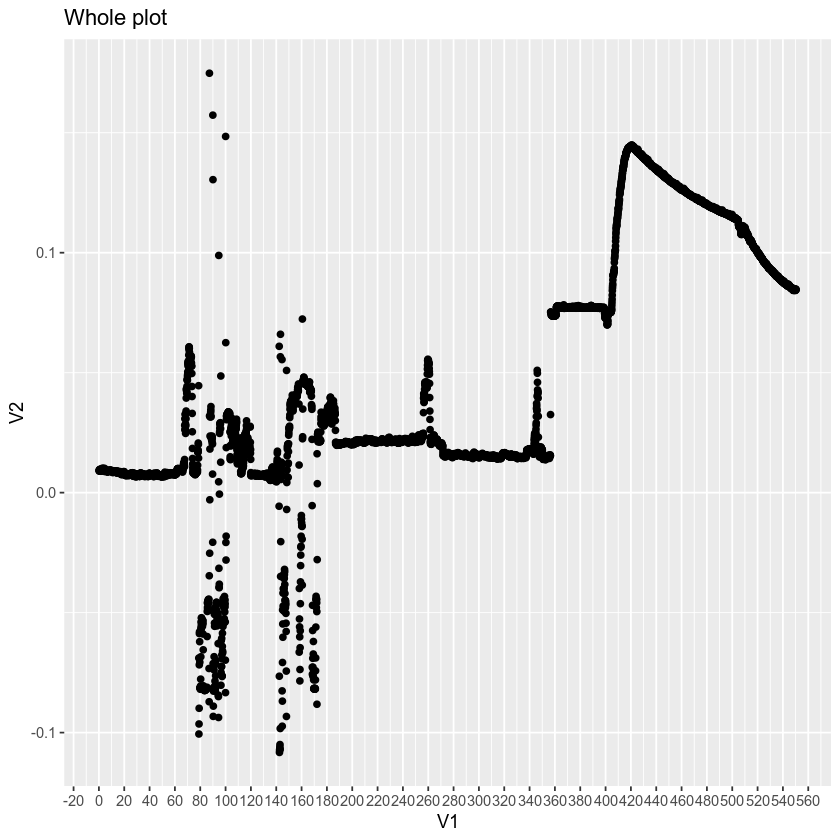

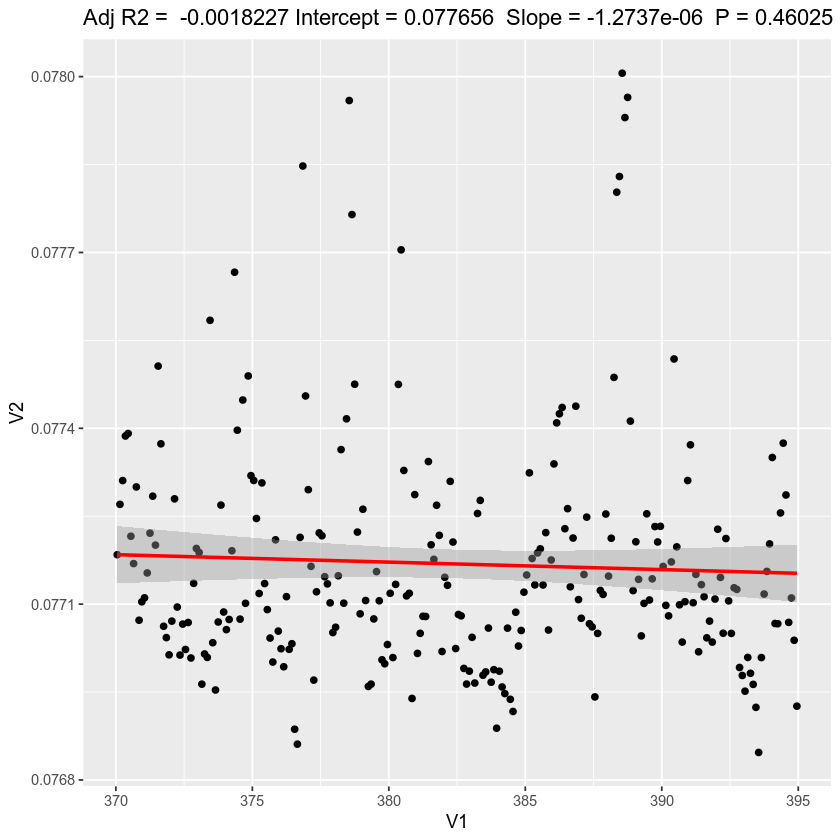

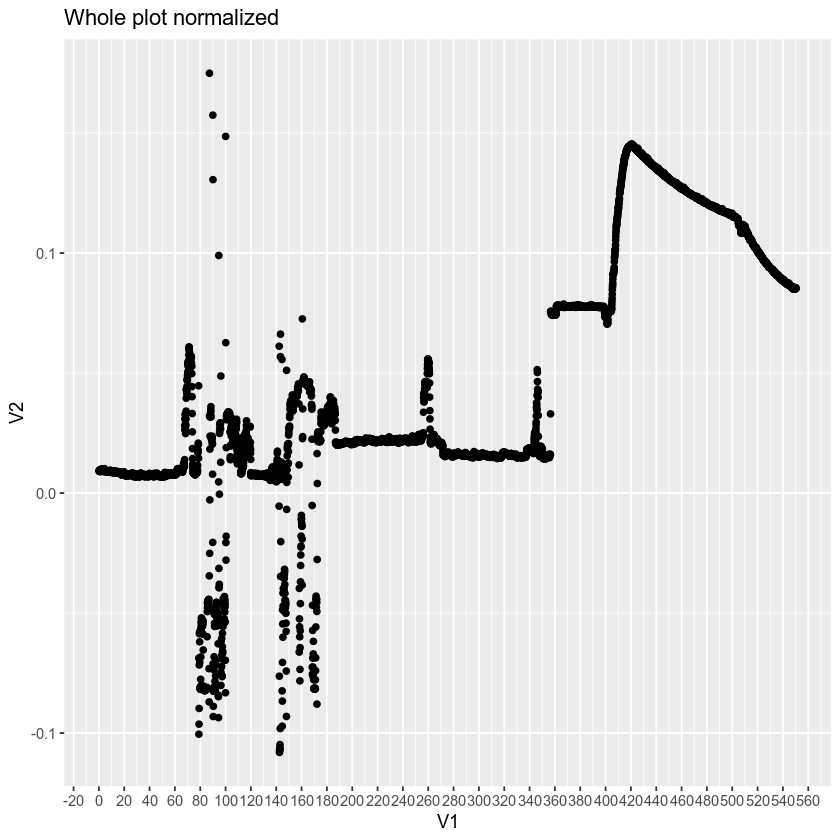

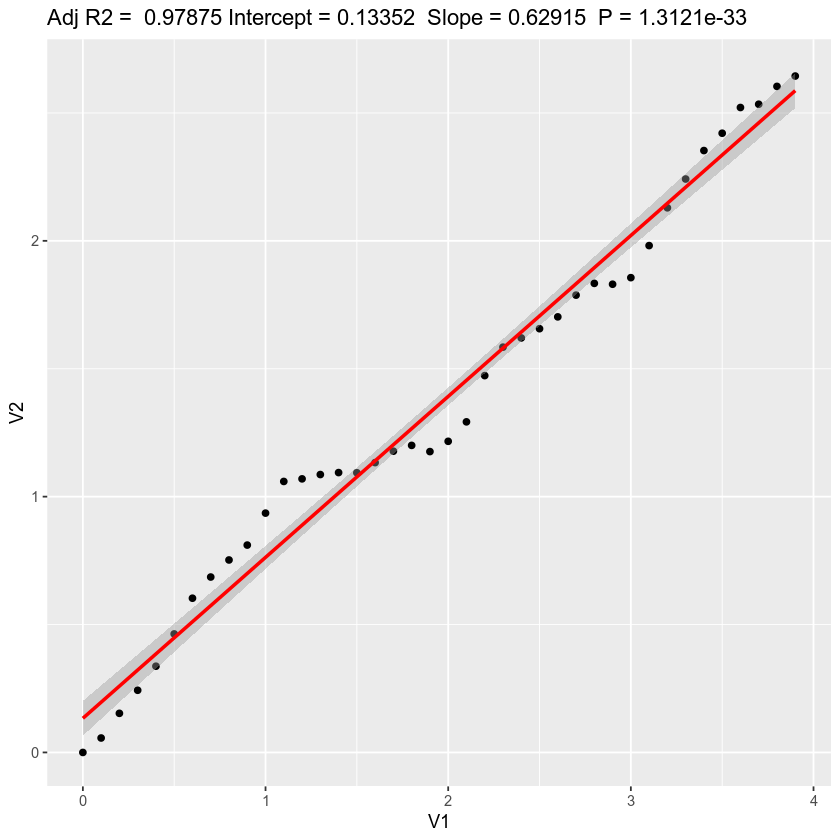

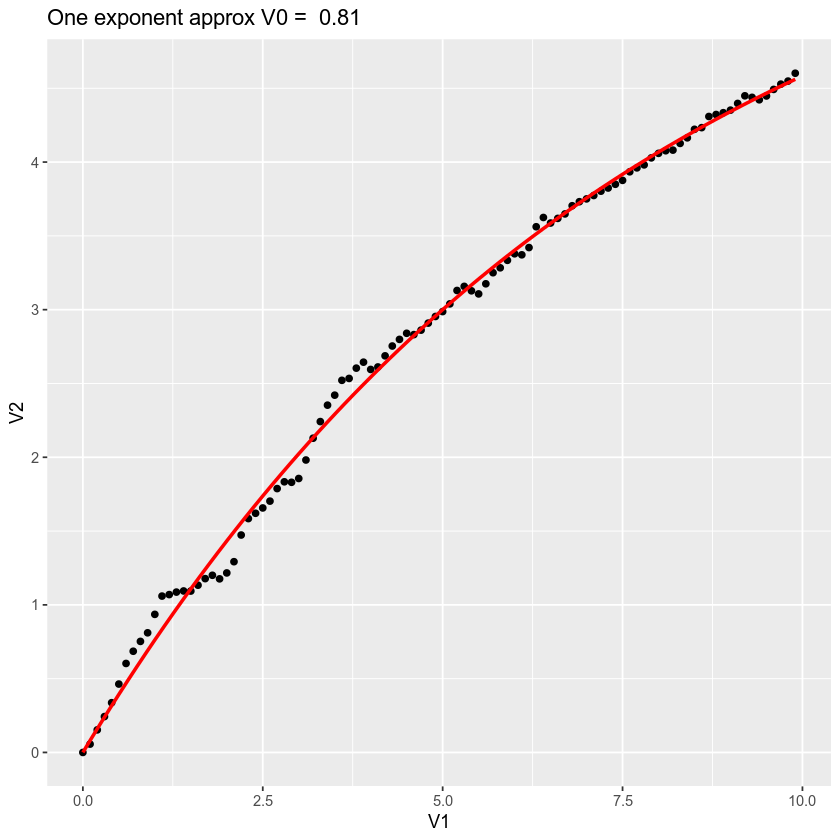

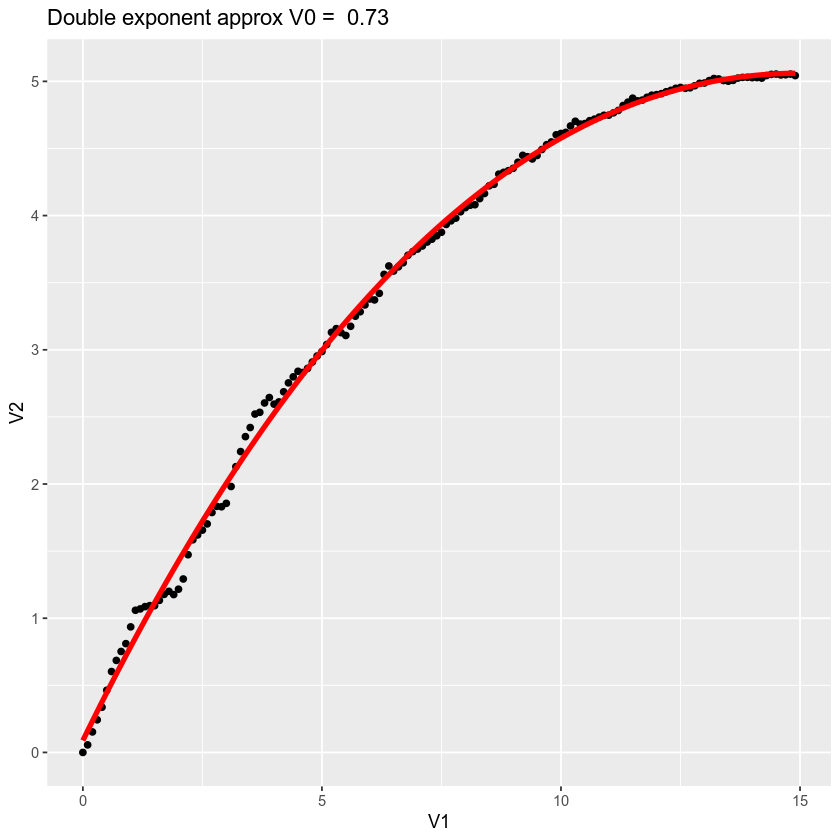

In [12]:
INDEX = 1

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 370
enzyme_start = 395
end_enzyme = 900

#Approximations
start_linear = 9.75
end_linear = 4
start_exp = start_linear
end_exp = 10
end_double_exp = 15
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T, 401, 430)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 2 experimental point (02-argon_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl_pghs10mkl)

SUBBORN ACTIVATED :)


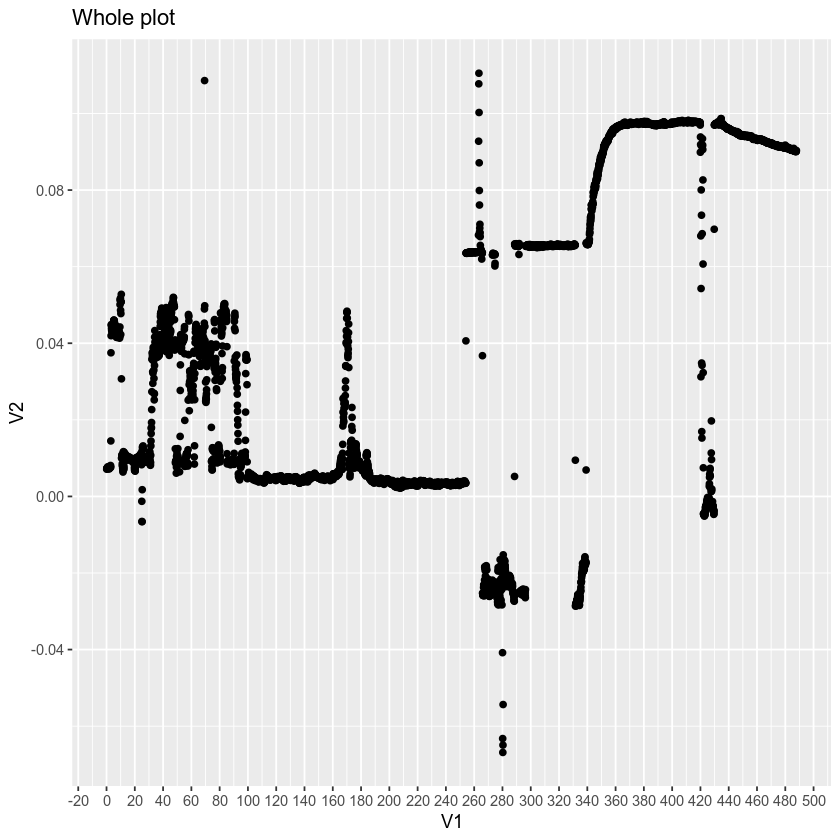

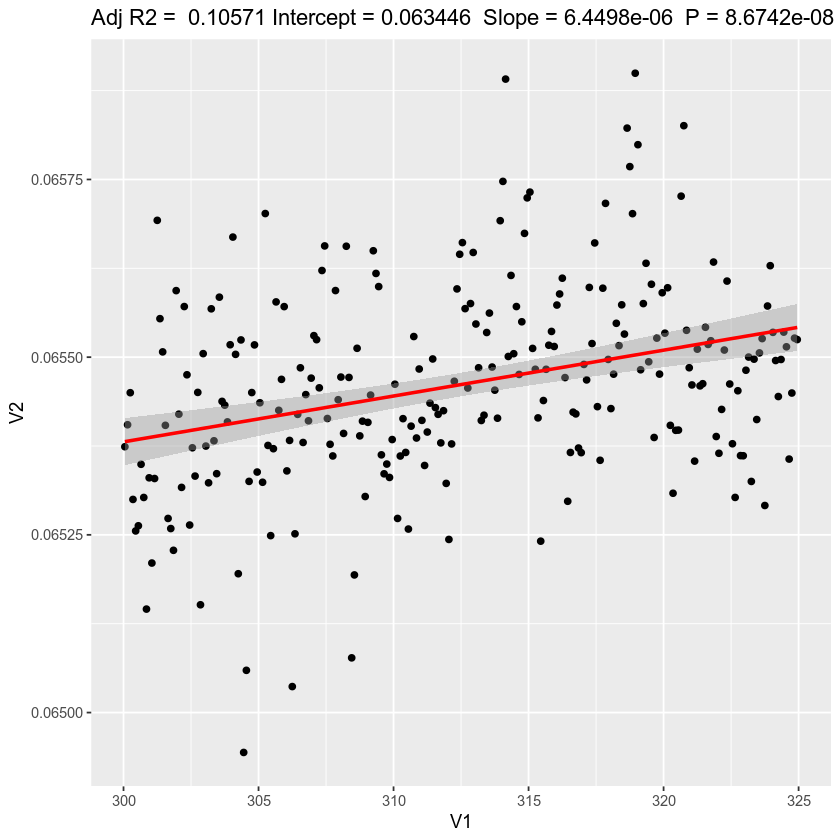

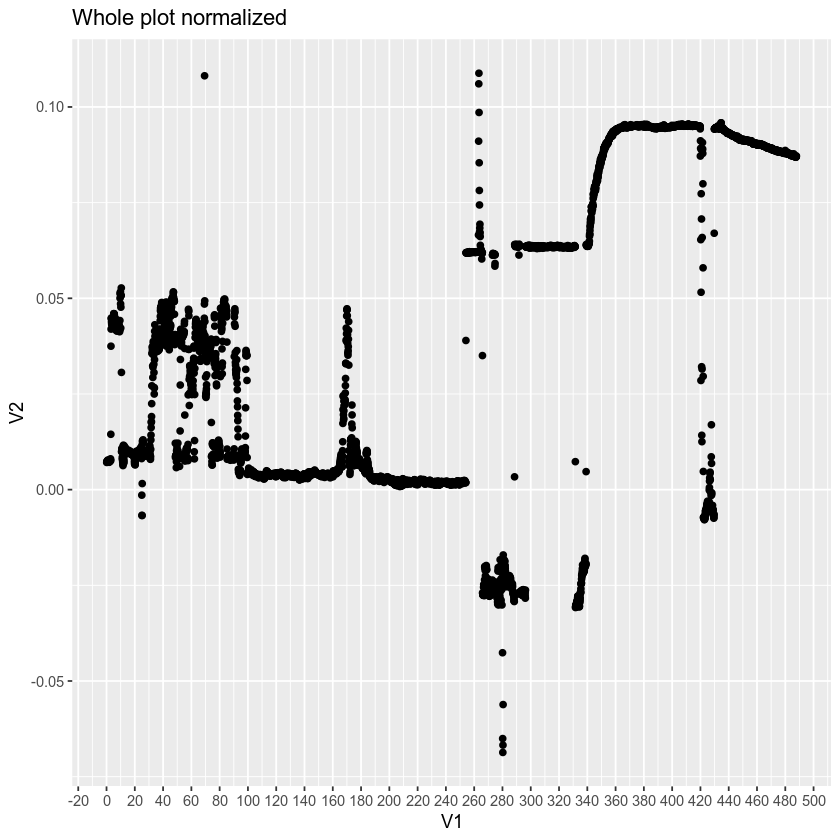

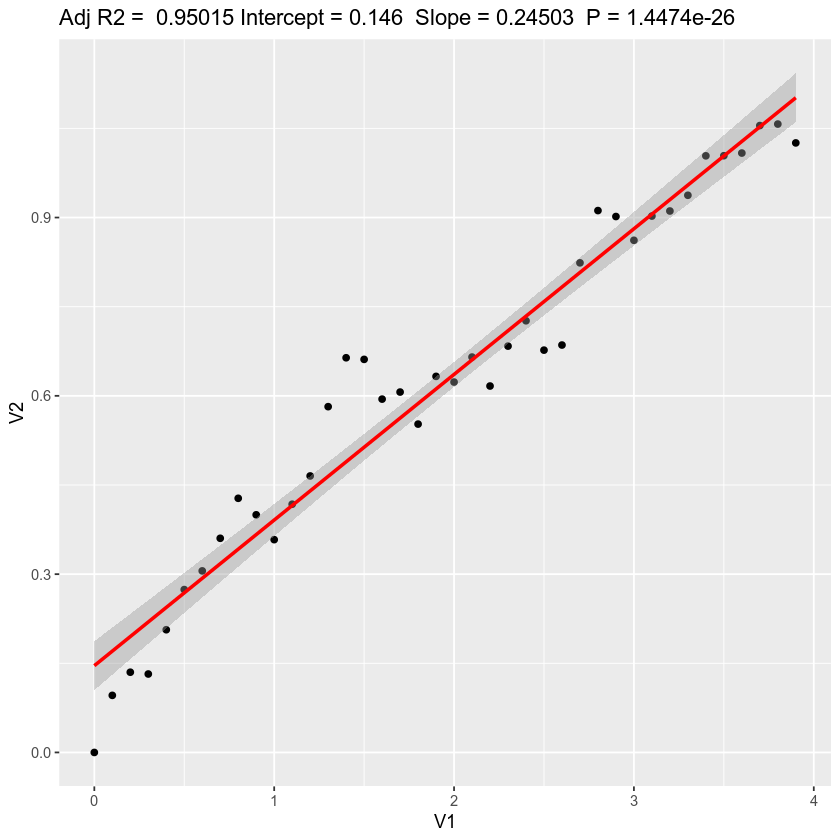

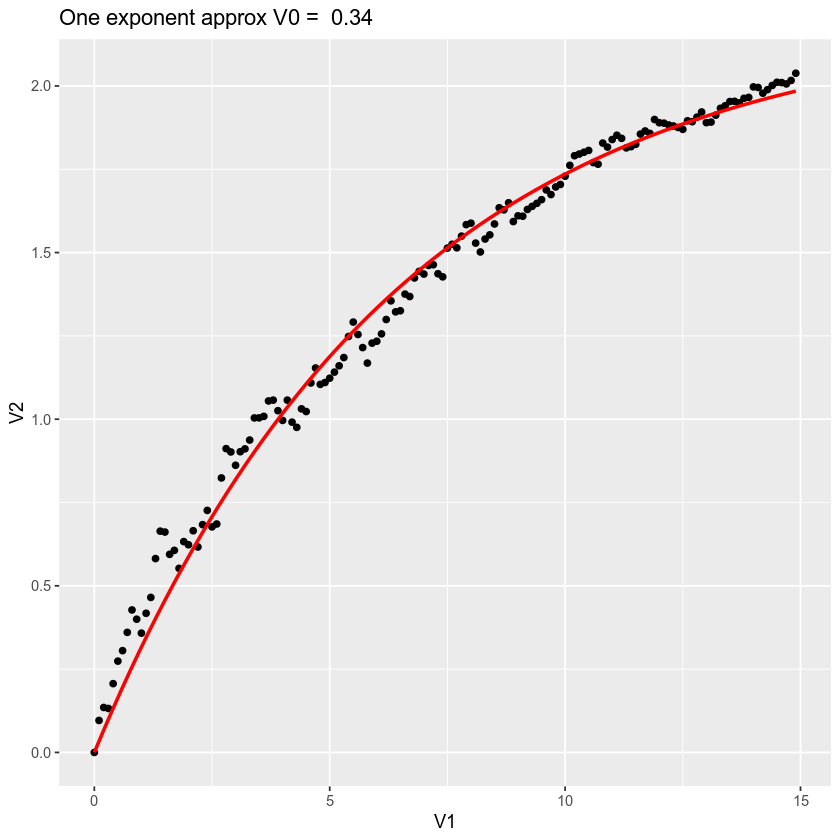

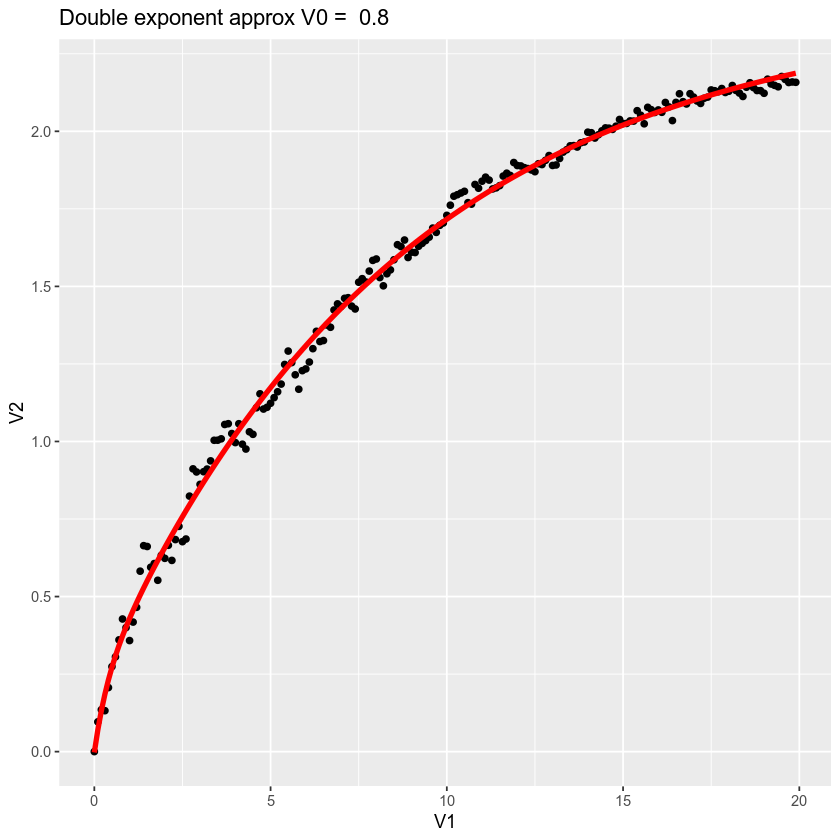

In [13]:
INDEX = 2

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 300
enzyme_start = 325
end_enzyme = 900

#Approximations
start_linear = 16.45
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 20
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 3 experimental point (03-oxygen_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl_pghs10mkl_hooh50mkM_tmpd5mkM)

SUBBORN ACTIVATED :)
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: singular convergence (7)”

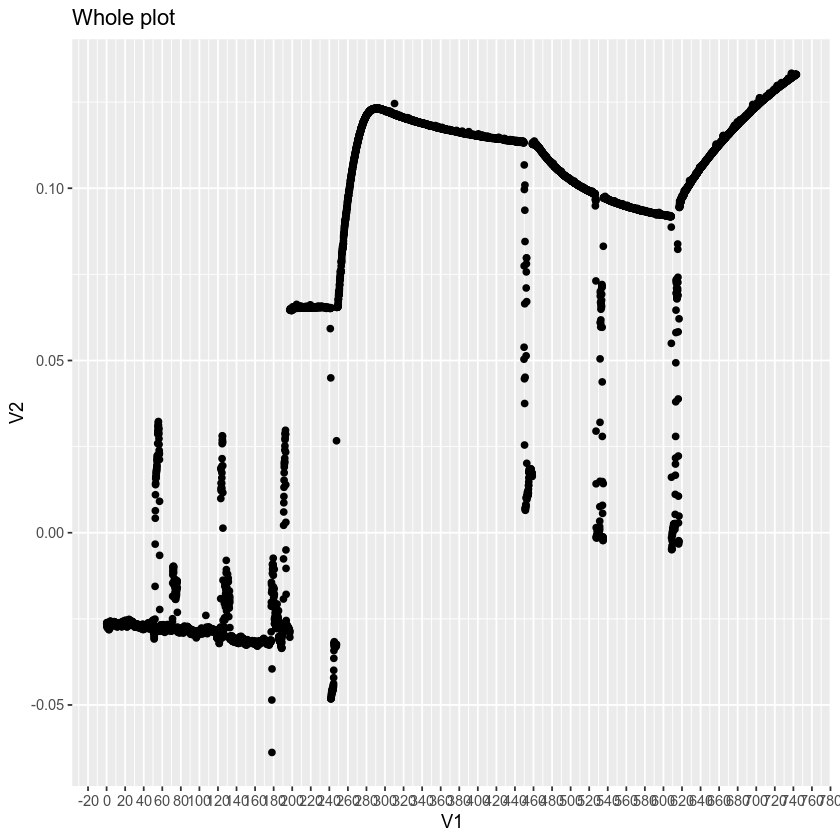

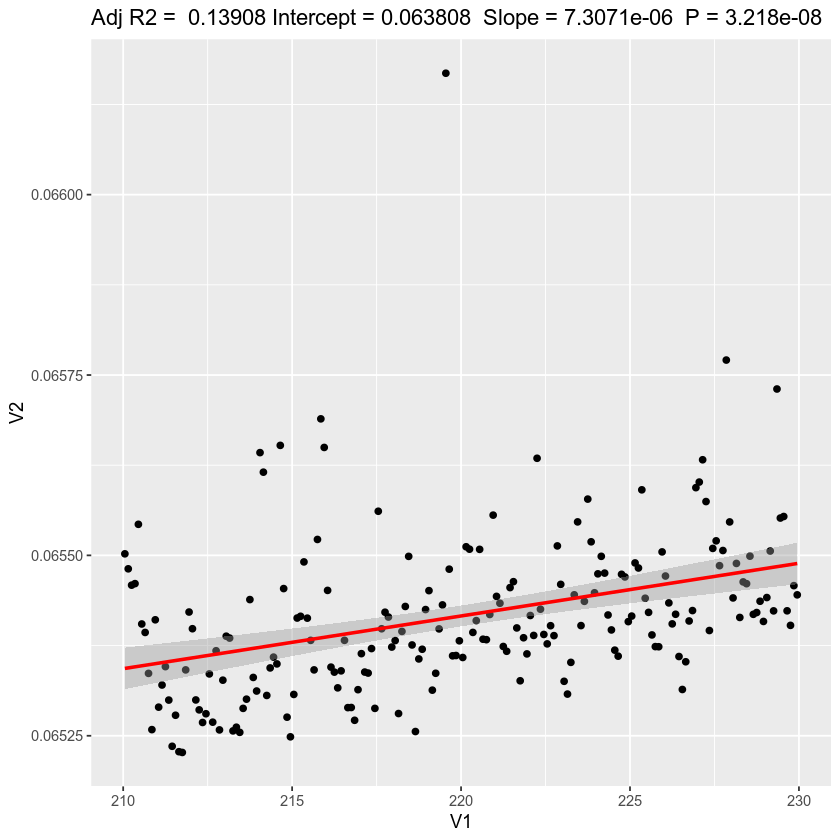

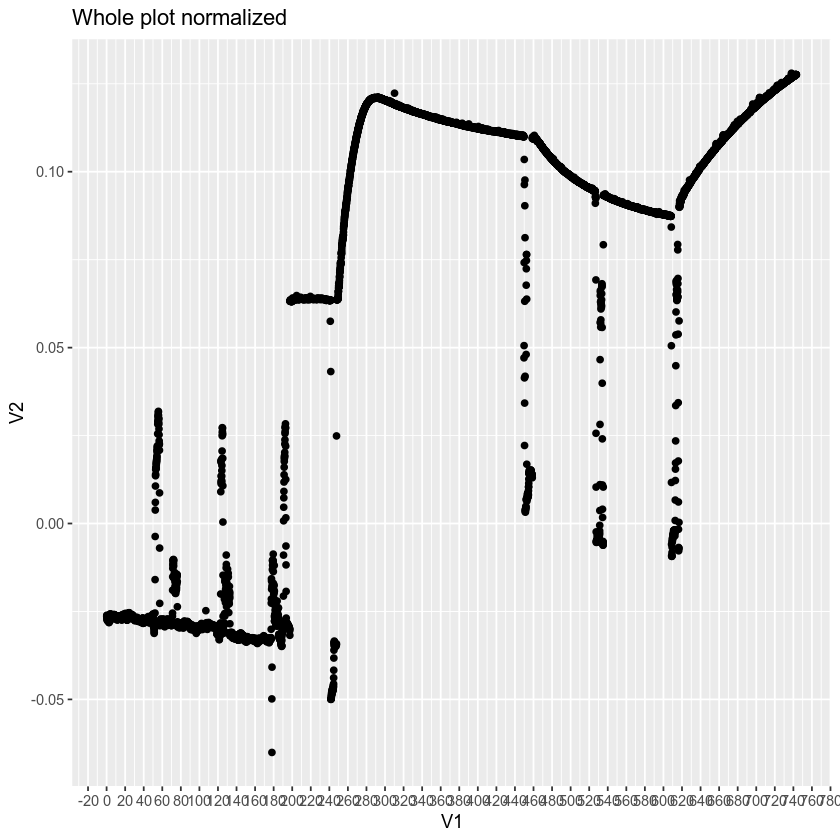

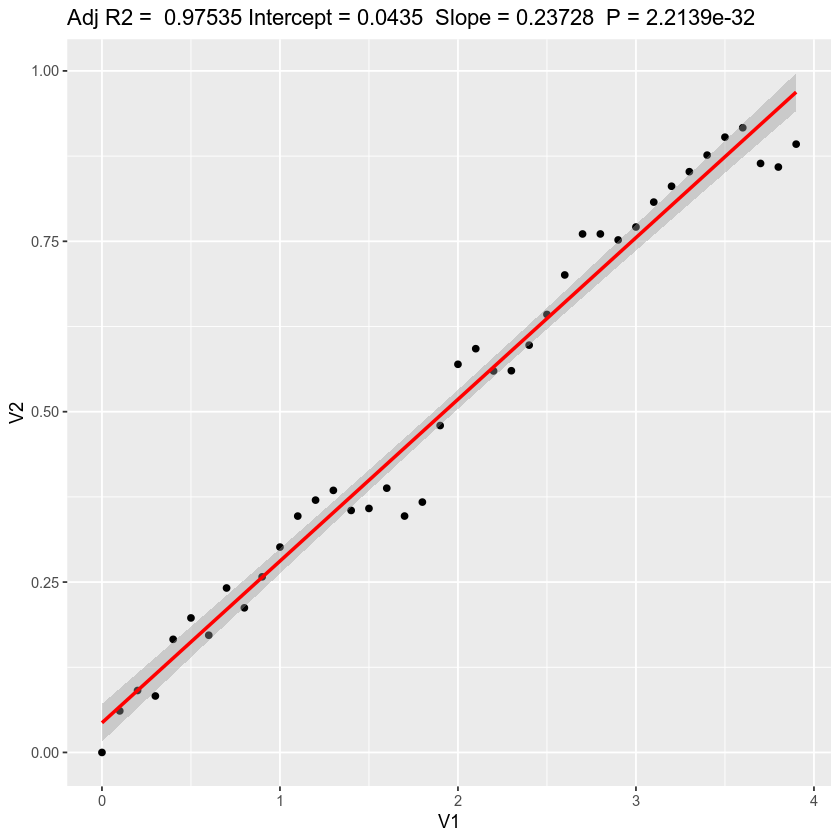

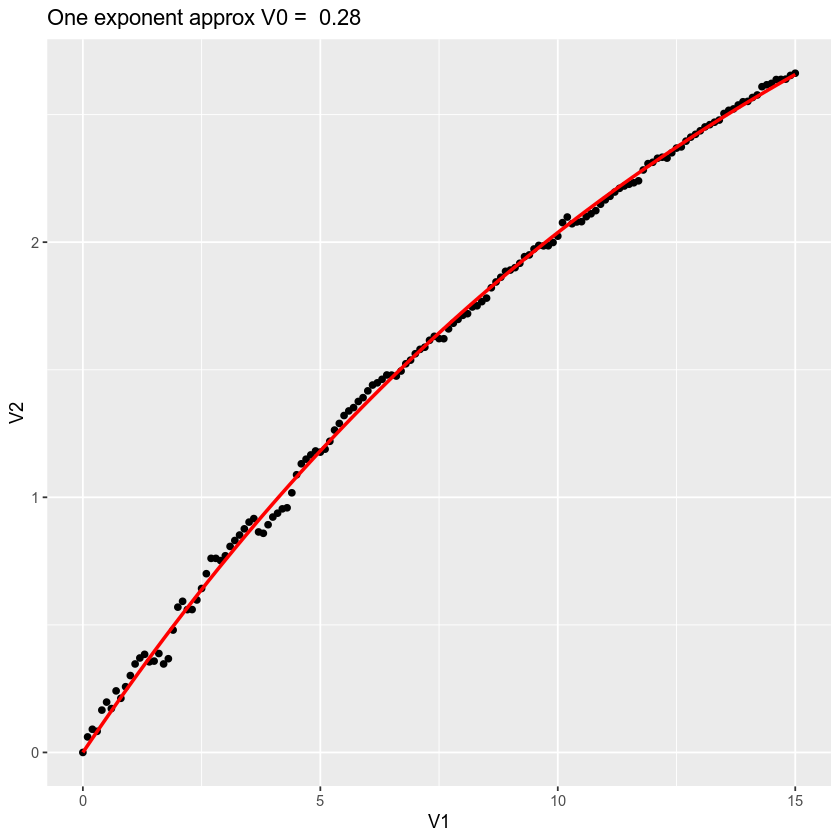

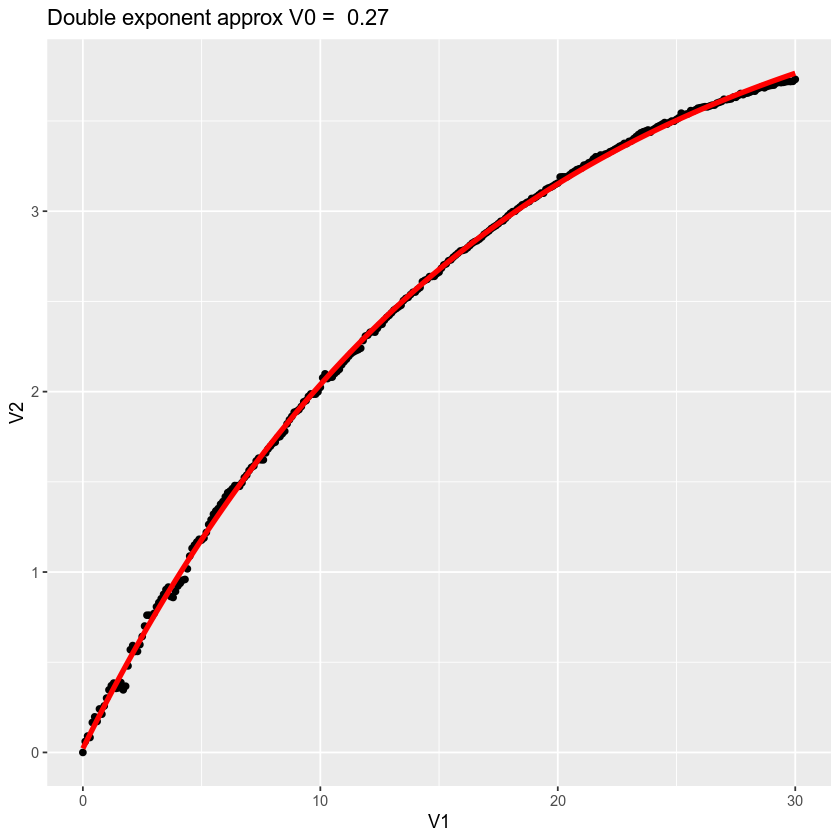

In [14]:
INDEX = 3

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 210
enzyme_start = 230
end_enzyme = 900

#Approximations
start_linear = 20.8
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 30
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 4 experimental point (04-oxygen_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl_pghs10mkl)

SUBBORN ACTIVATED :)


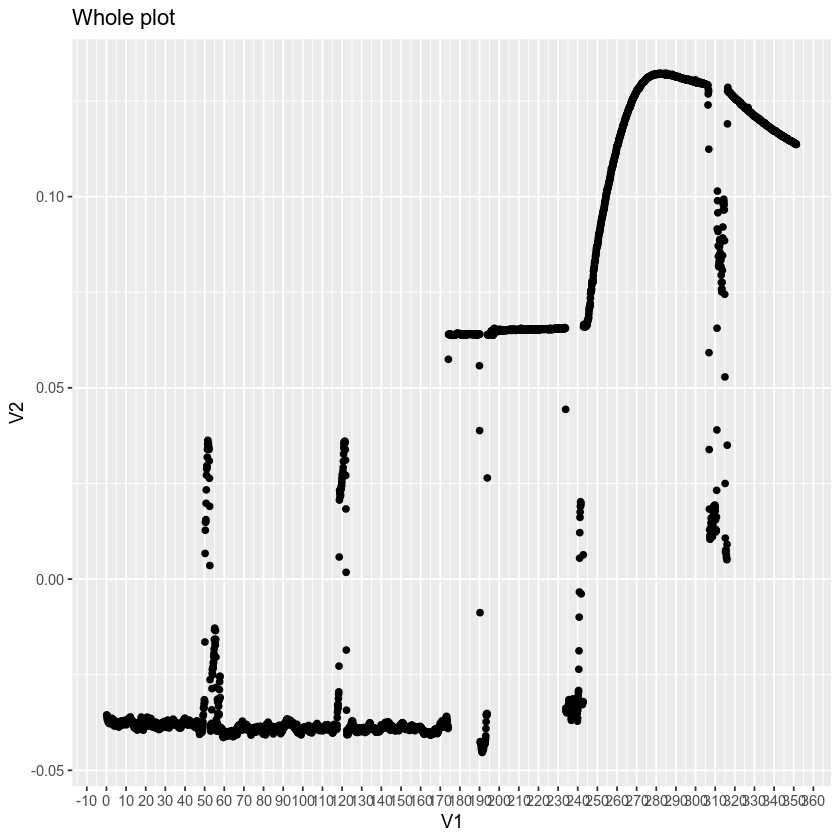

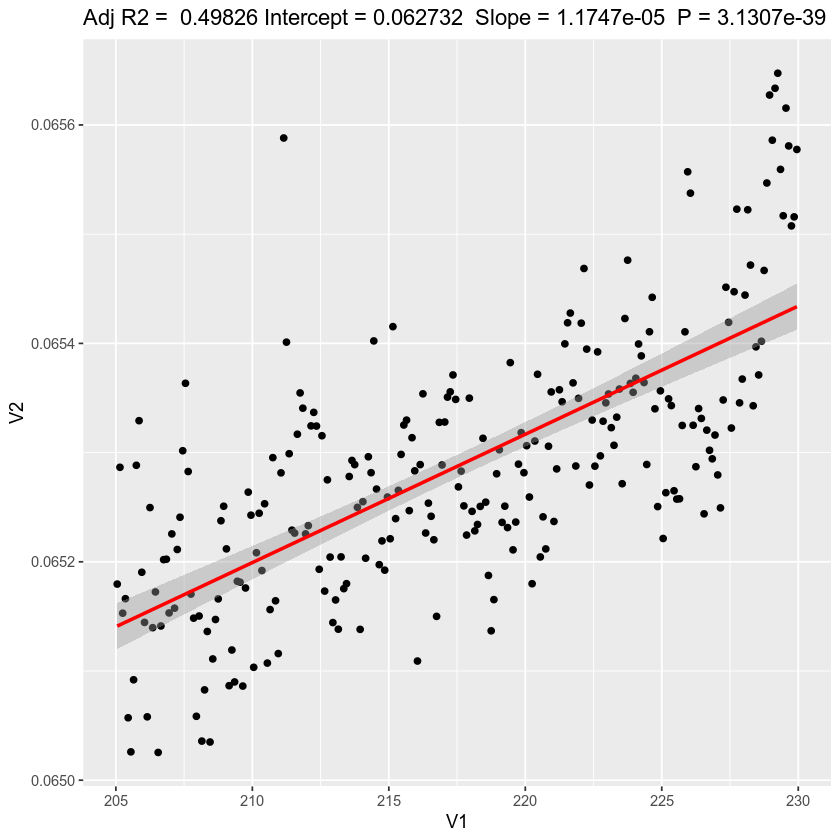

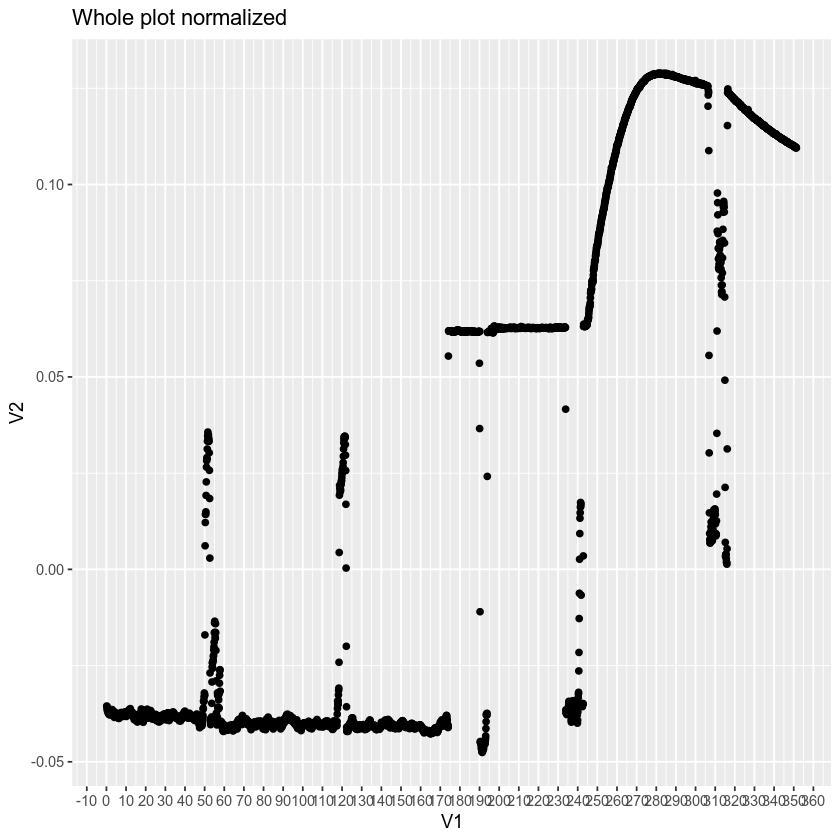

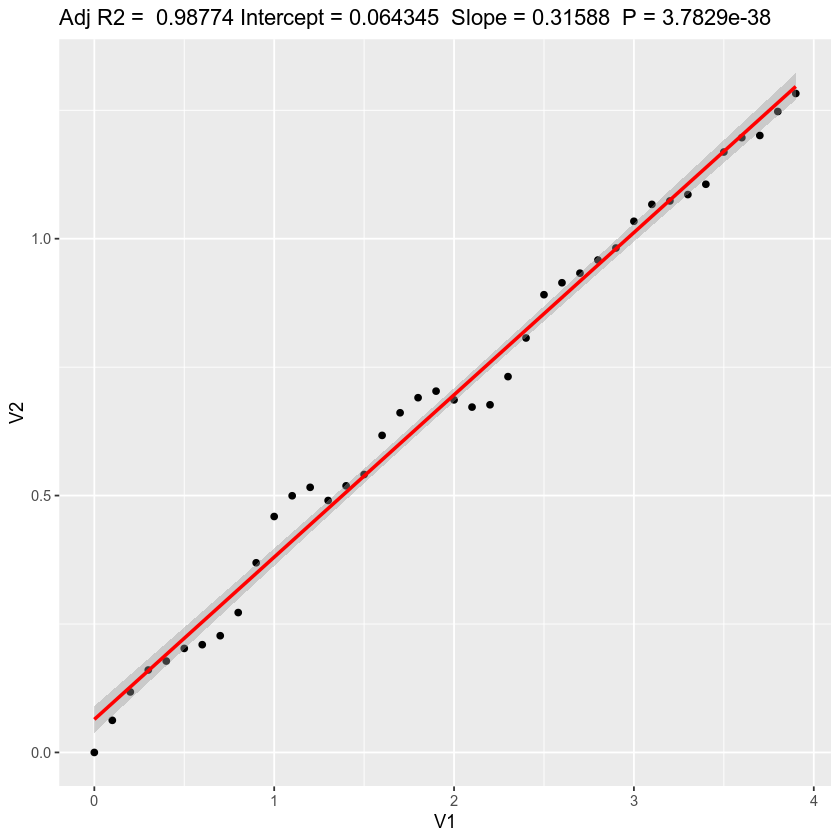

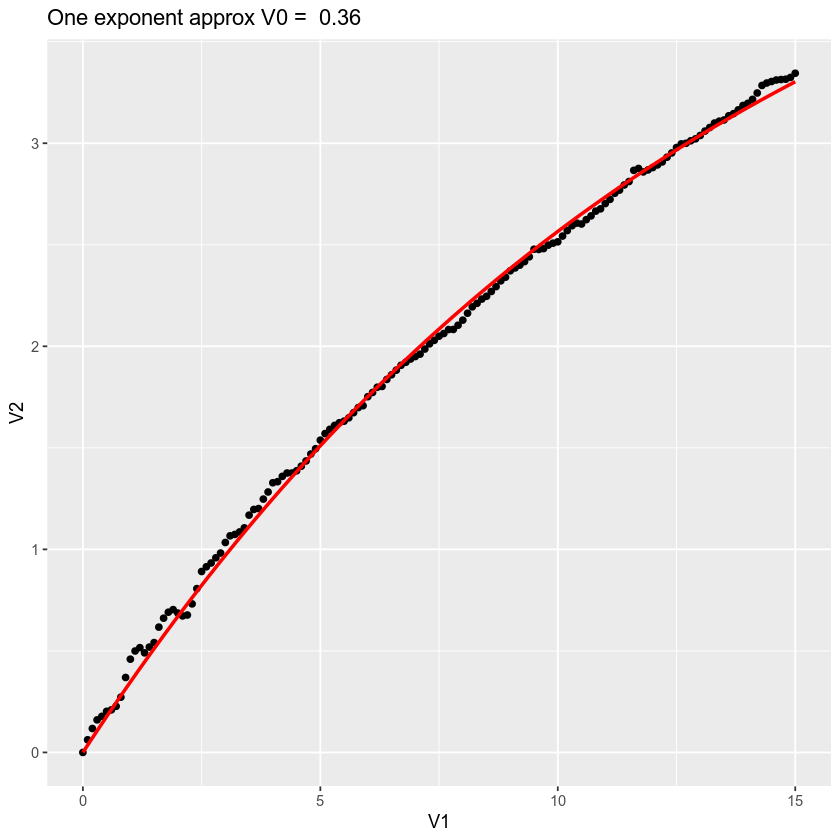

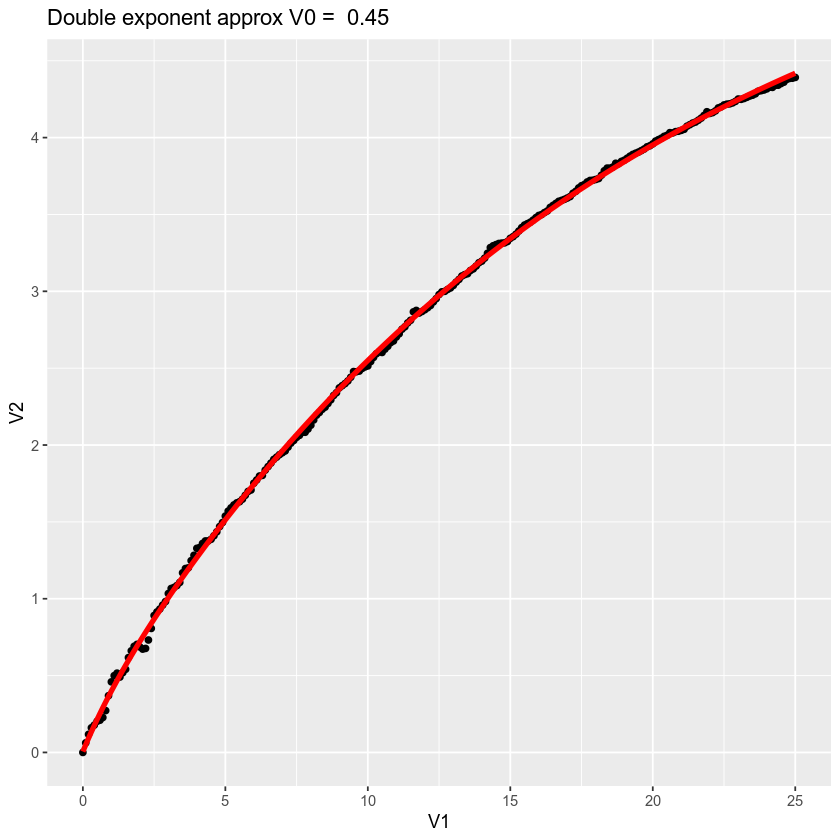

In [15]:
INDEX = 4

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 205
enzyme_start = 230
end_enzyme = 900

#Approximations
start_linear = 15.5
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 25

# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 5 experimental point (05-argon_tween0_1_hooh50mkM_tmpd5mkM_napr400mkM_pghs10mkl_)

SUBBORN ACTIVATED :)
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: false convergence (8)”

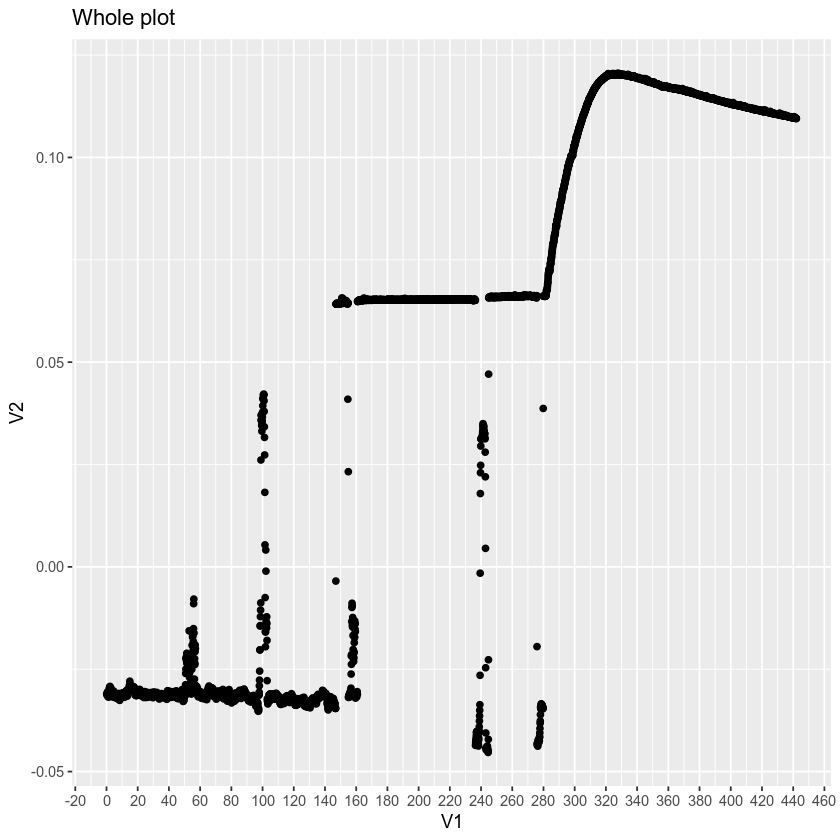

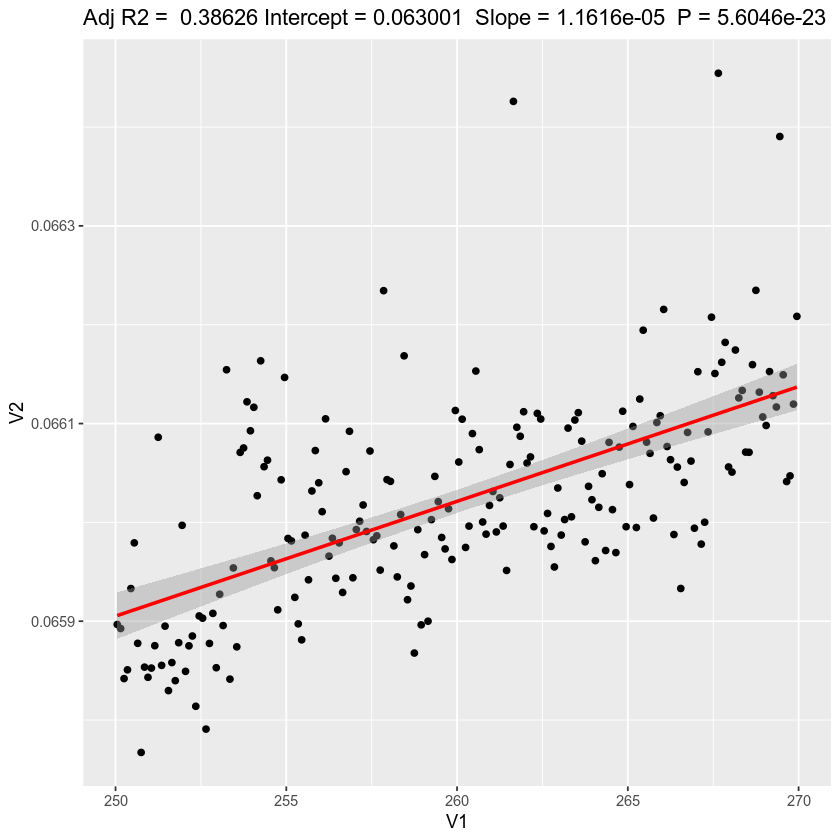

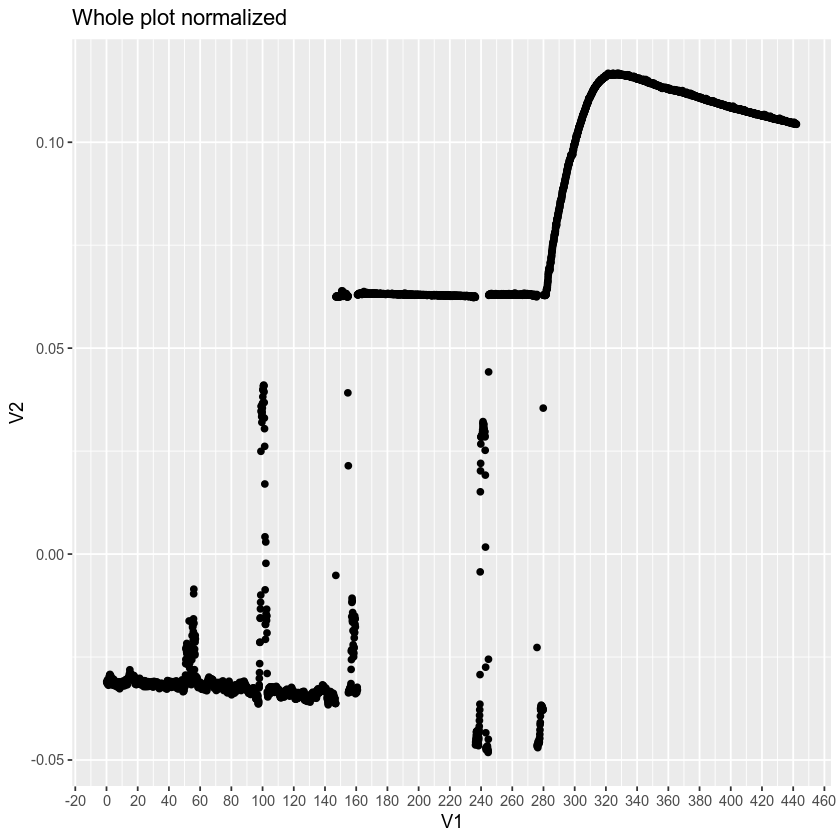

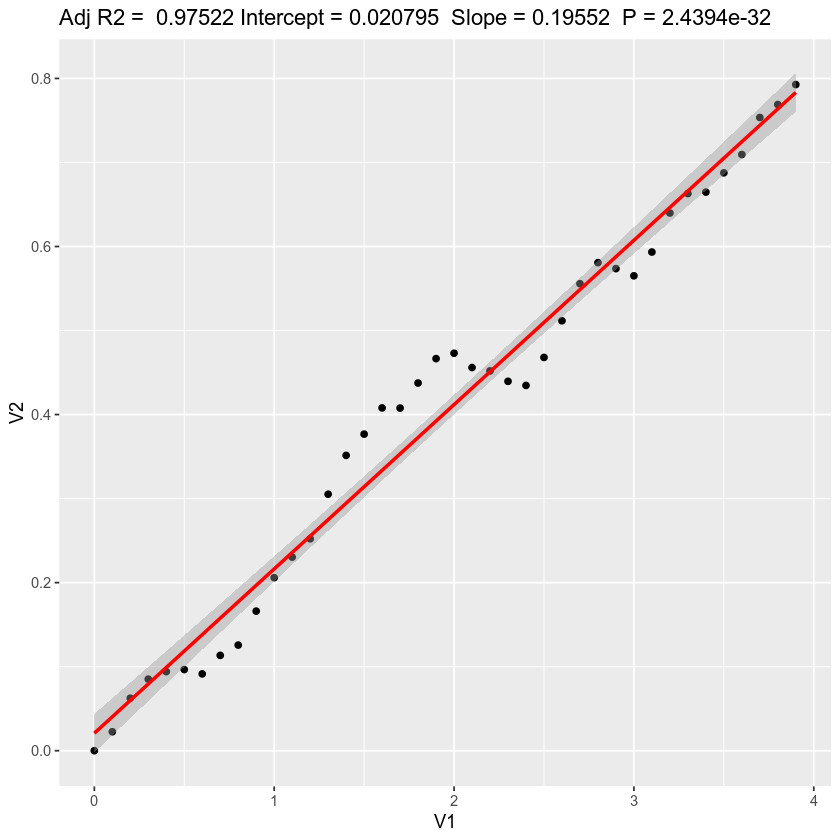

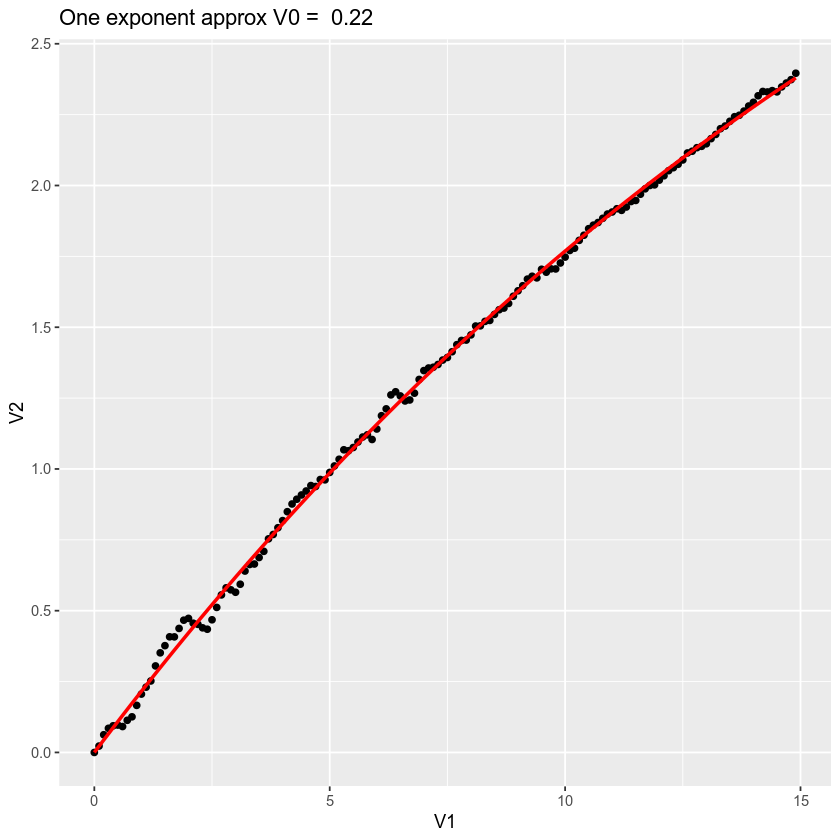

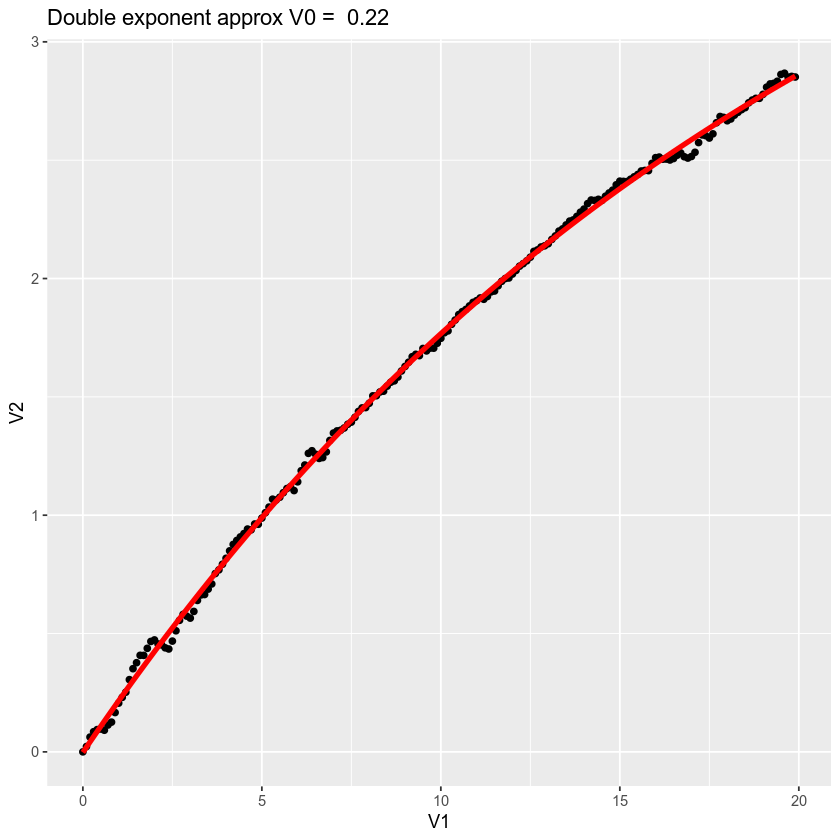

In [16]:
INDEX = 5

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 250
enzyme_start = 270
end_enzyme = 900

#Approximations
start_linear = 11.6
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 20
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 6 experimental point (06-argon_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl)

SUBBORN ACTIVATED :)


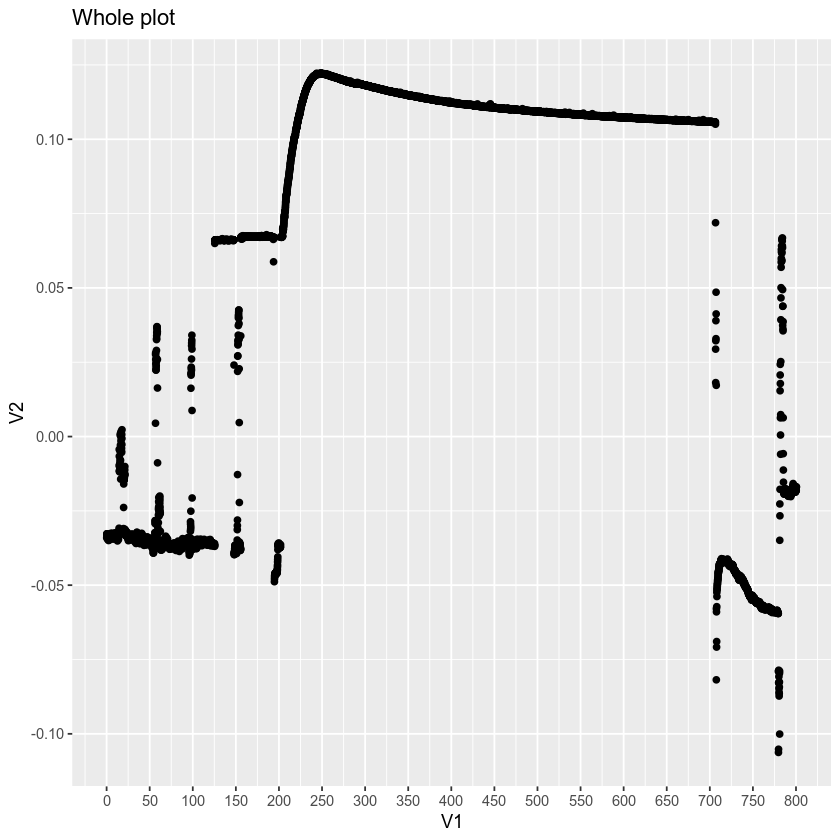

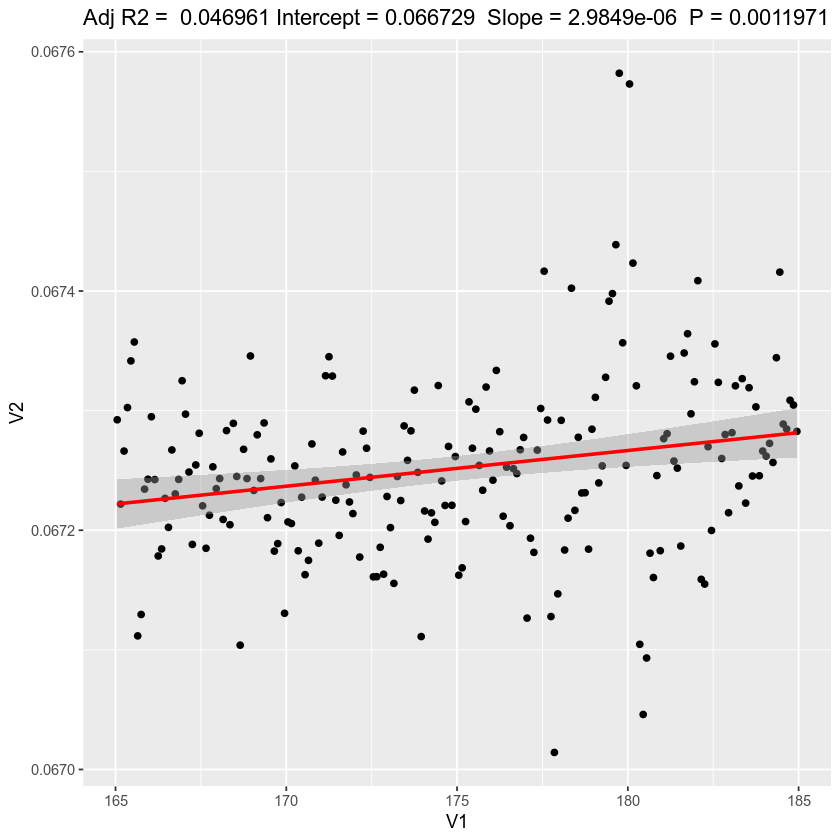

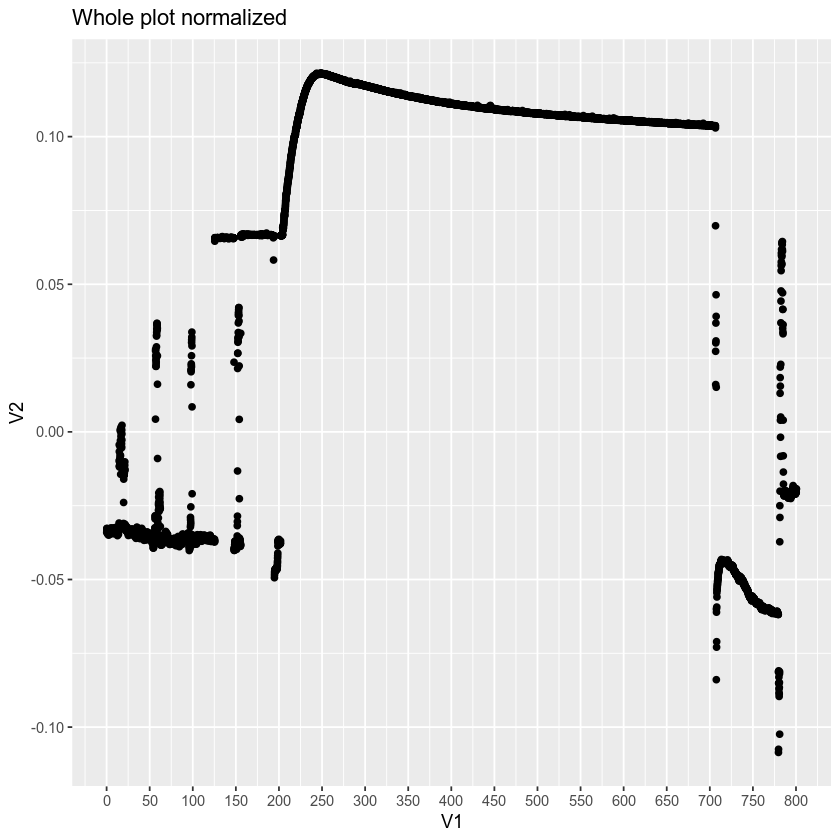

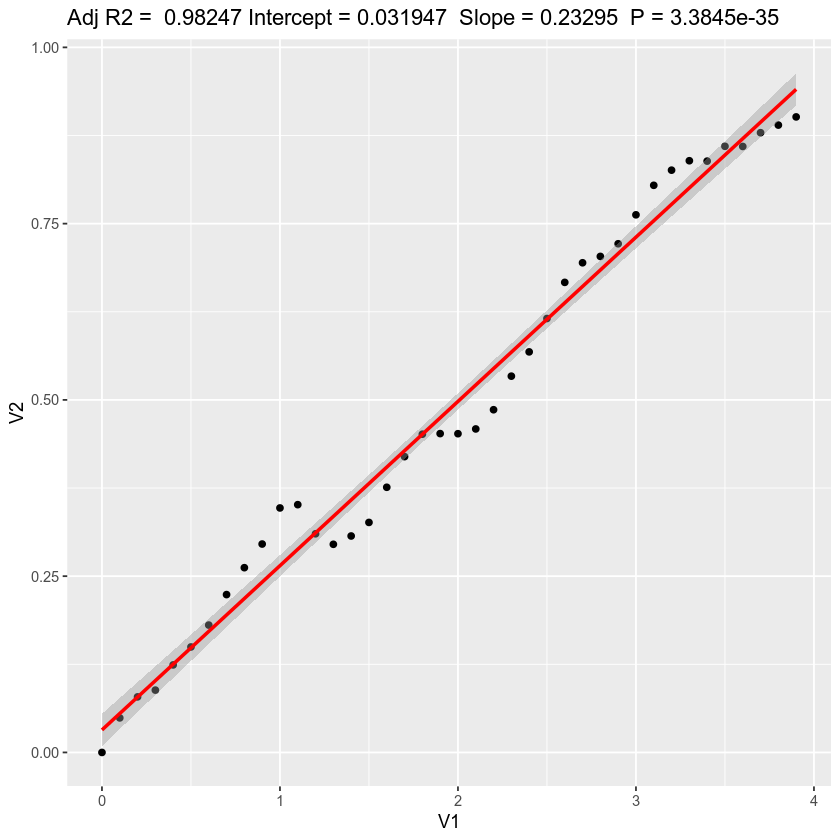

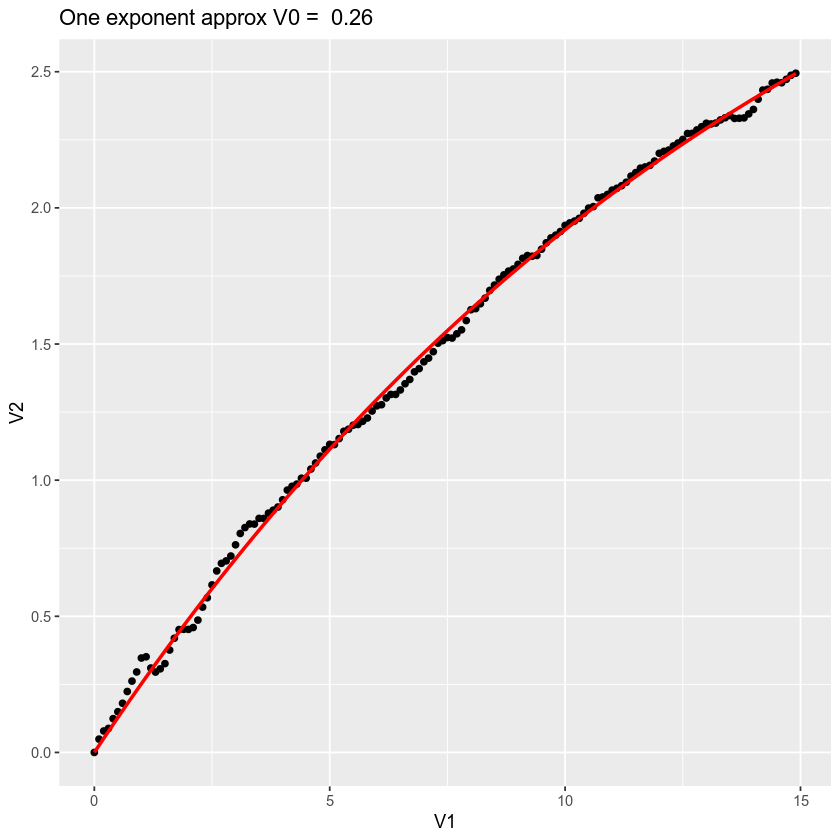

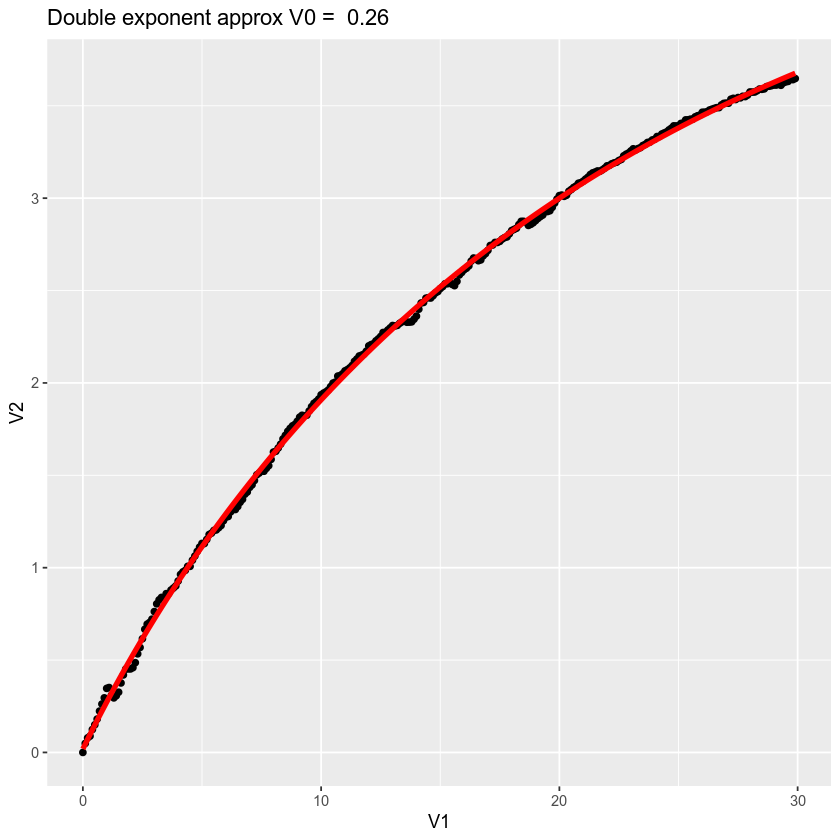

In [21]:
INDEX = 6

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 165
enzyme_start = 185
end_enzyme = 900

#Approximations
start_linear = 20.1
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 30
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 7 experimental point (07-oxygen_tween0_1_hooh50mkM_tmpd5mkM_napr400mkM_pghs10mkl)

SUBBORN ACTIVATED :)
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: function evaluation limit reached without convergence (9)”

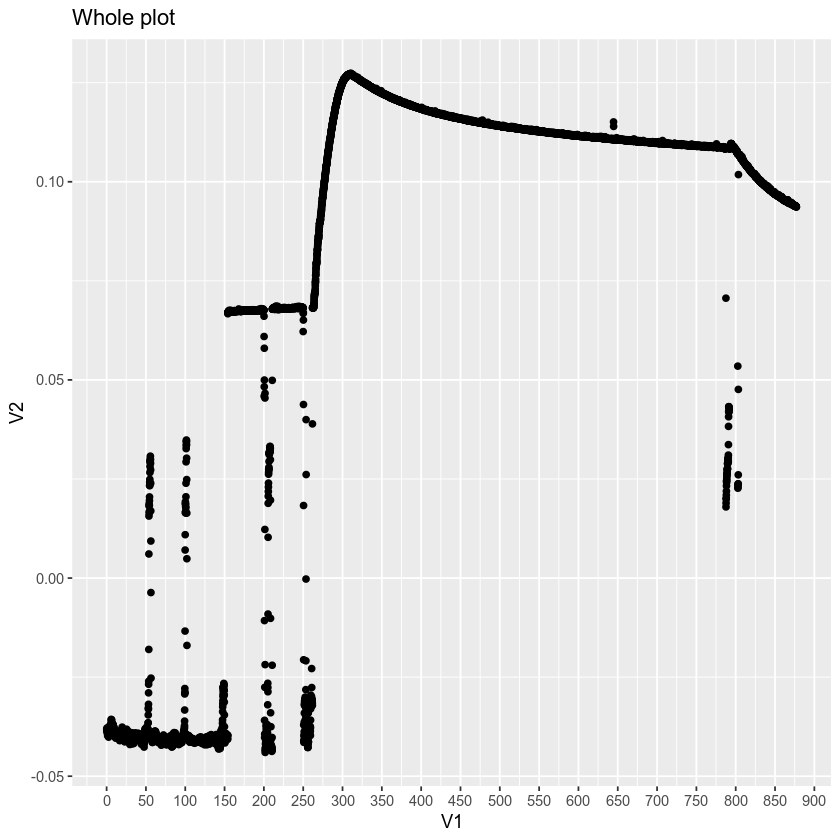

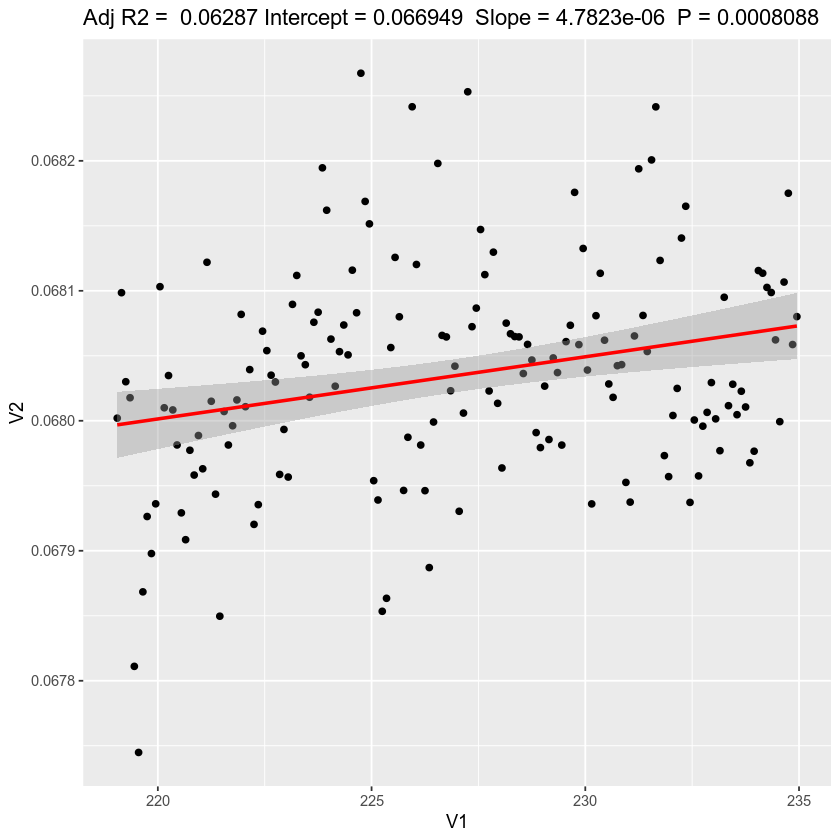

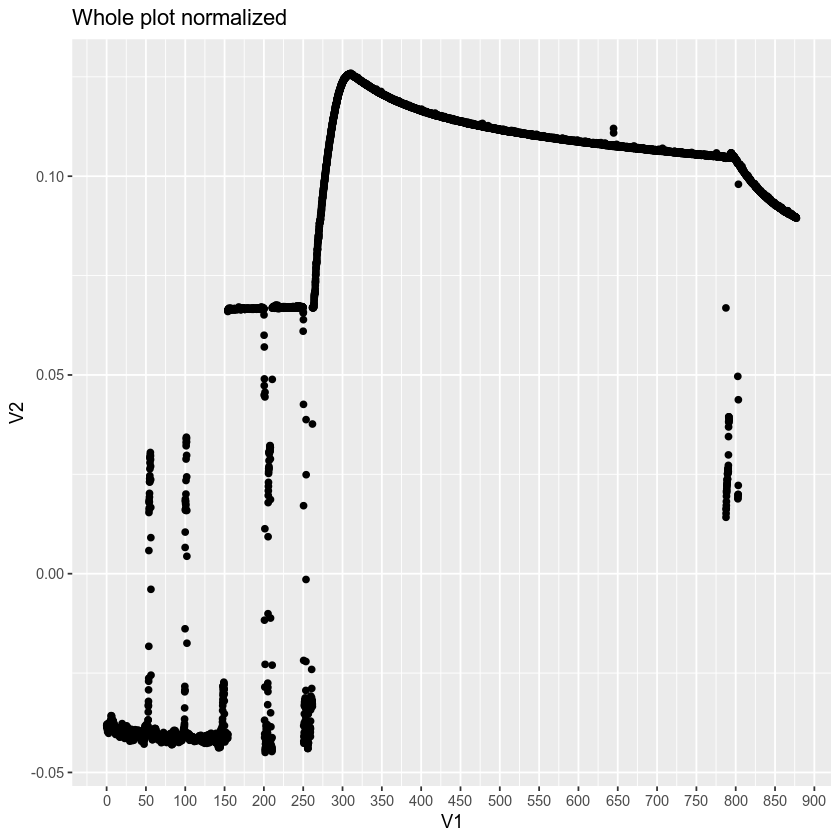

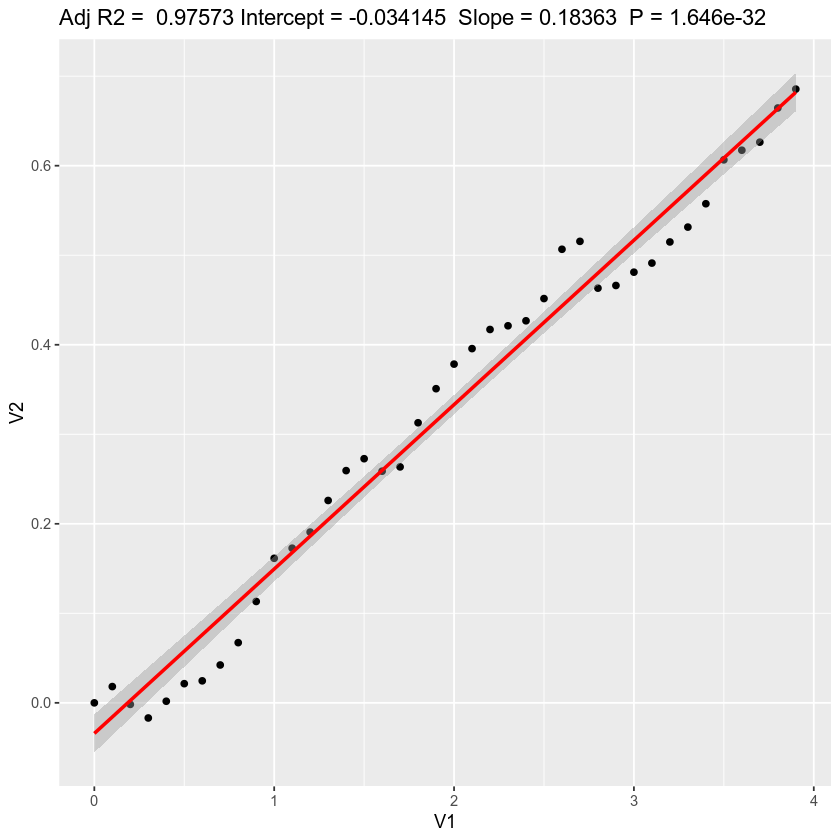

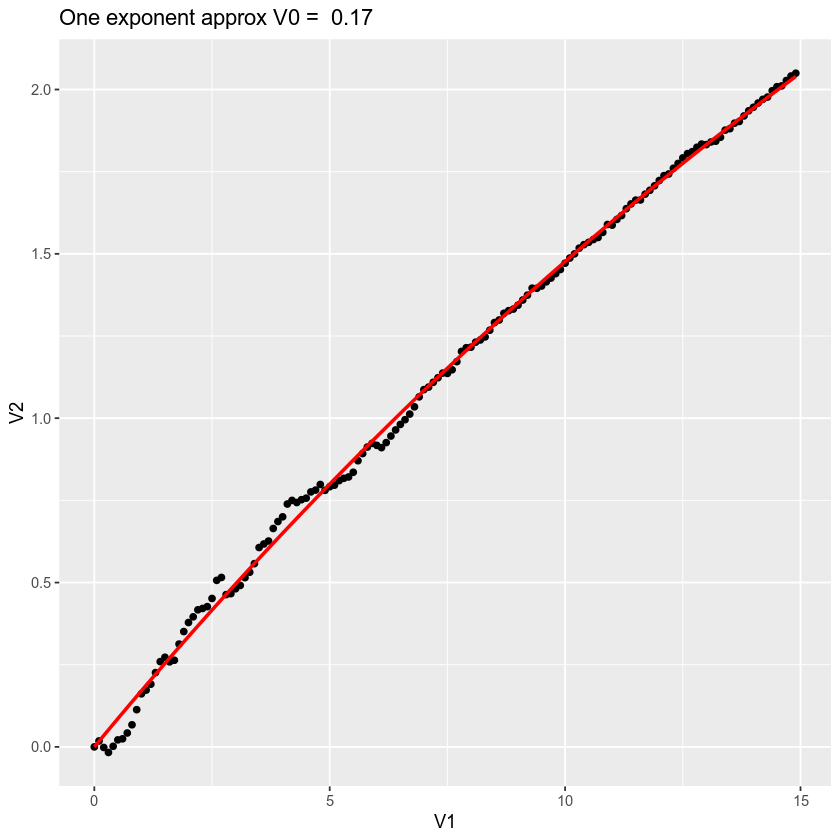

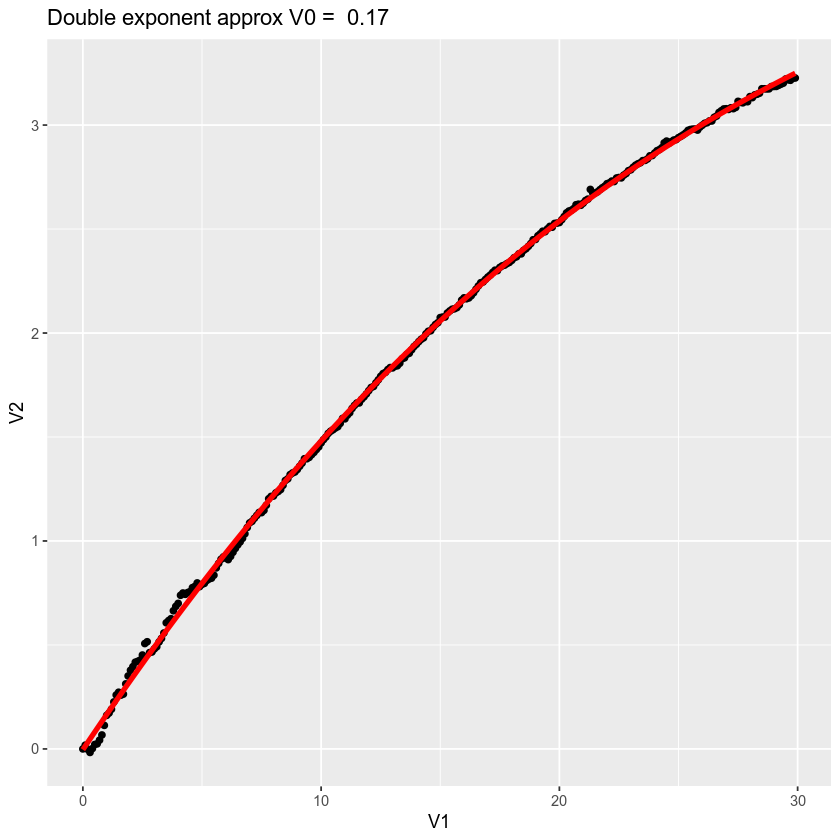

In [30]:
INDEX = 7

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 219
enzyme_start = 235
end_enzyme = 900

#Approximations
start_linear = 31.5
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 30
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 8 experimental point (08-air_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl)

SUBBORN ACTIVATED :)


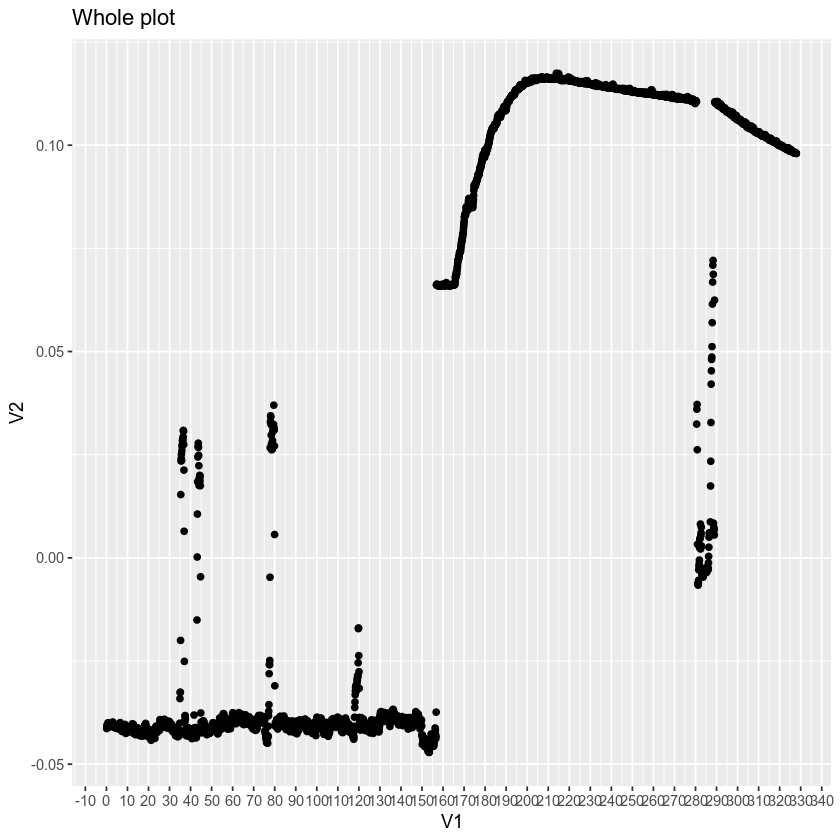

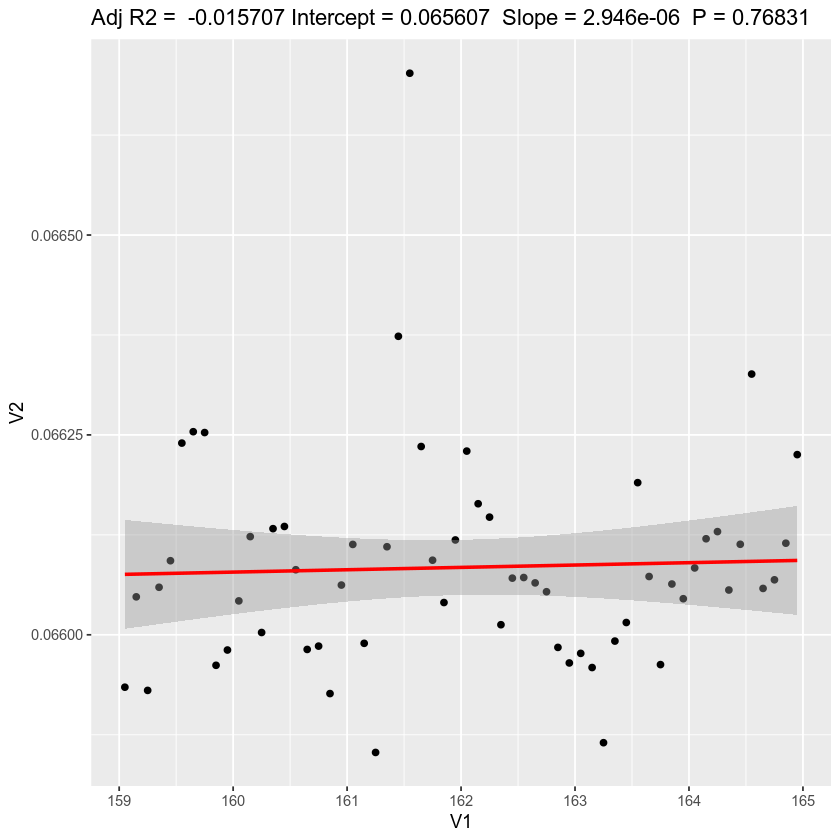

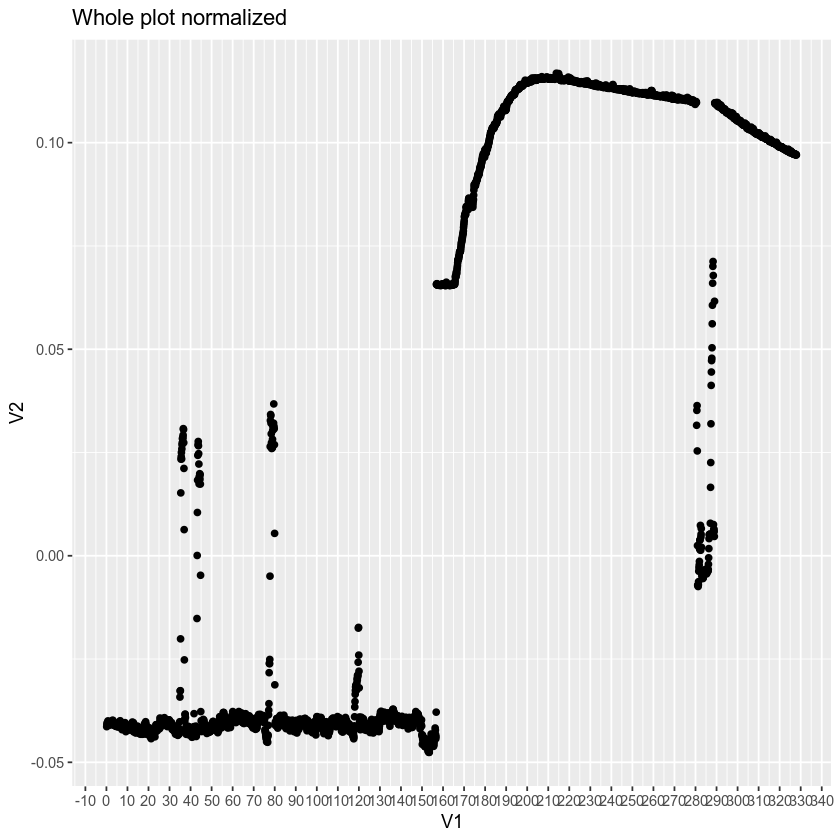

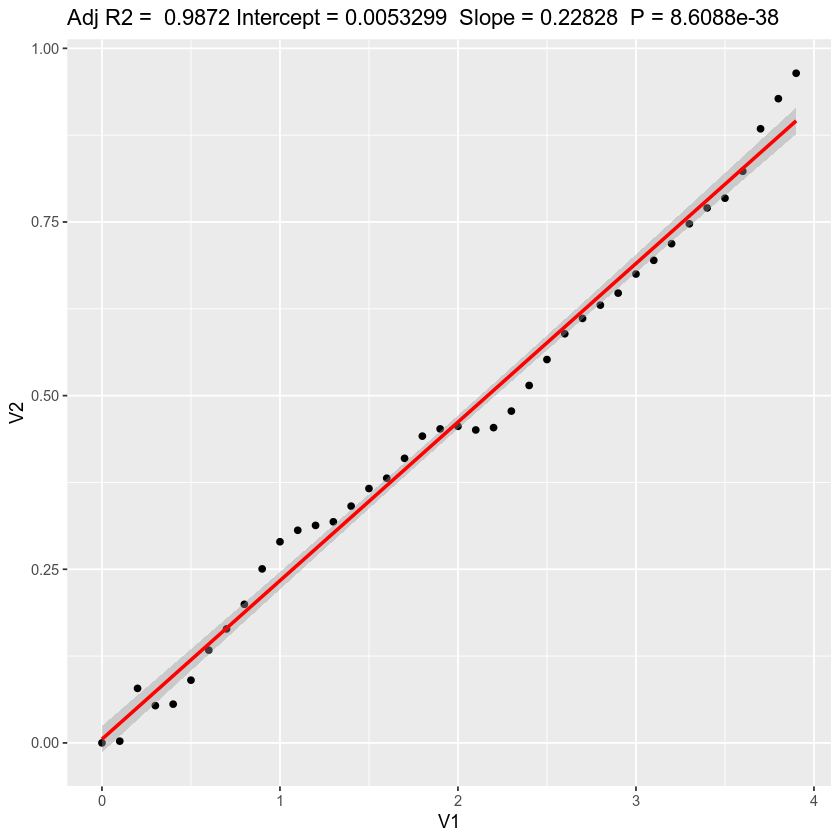

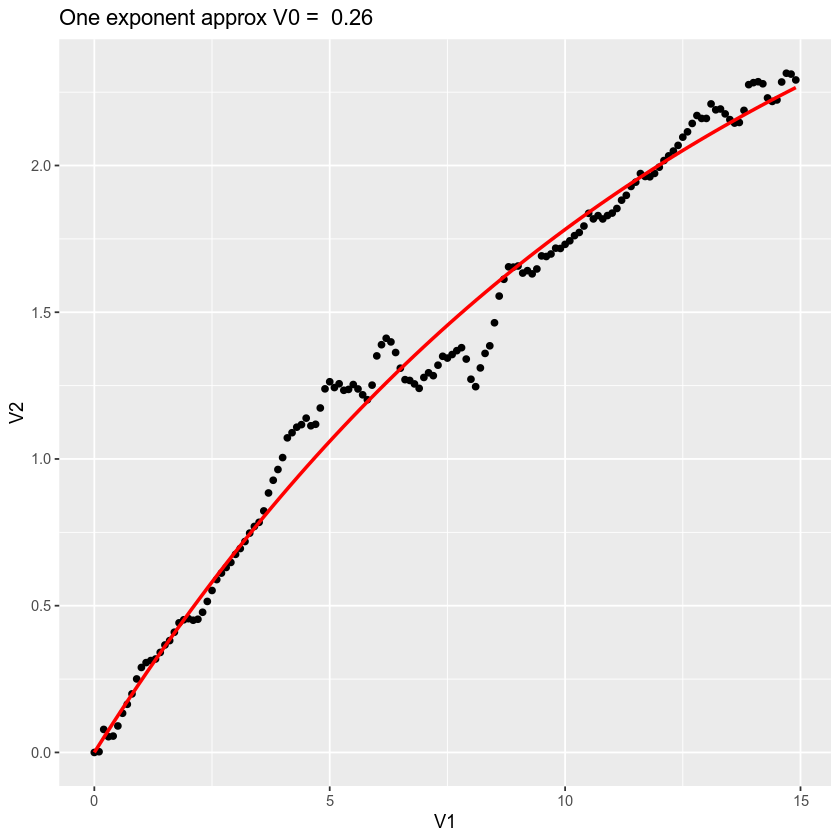

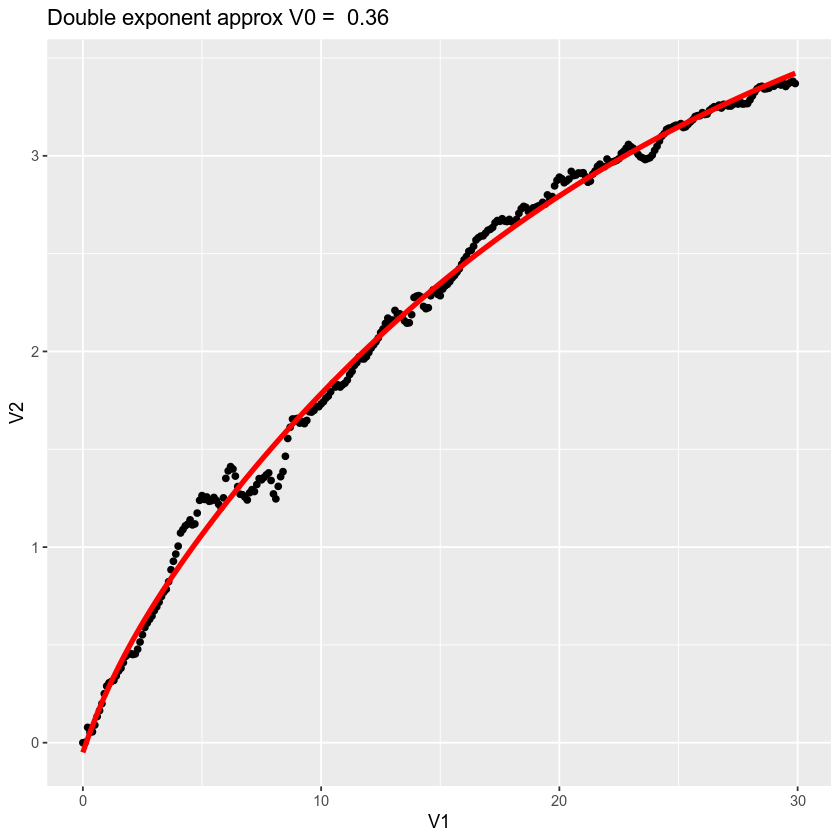

In [37]:
INDEX = 8

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 159
enzyme_start = 165
end_enzyme = 900

#Approximations
start_linear = 1
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 30
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 9 experimental point (09-air_tween0_1_hooh50mkM_tmpd5mkM_napr400mkM_pghs10mkl)

No nonezymatic part found! Ignoring normalization.
SUBBORN ACTIVATED :)


NULL

NULL

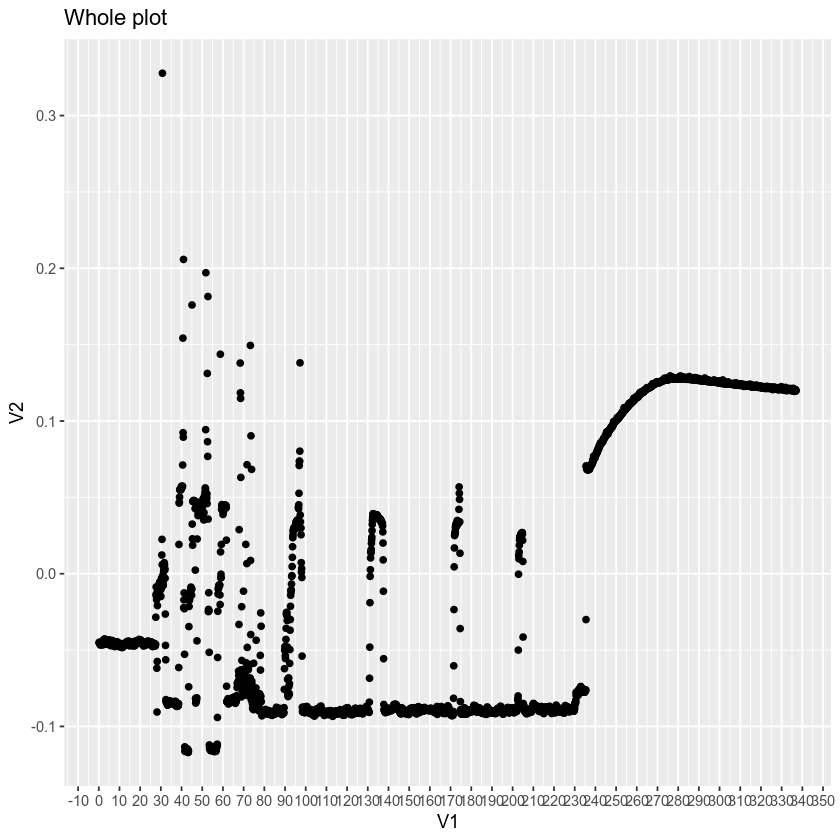

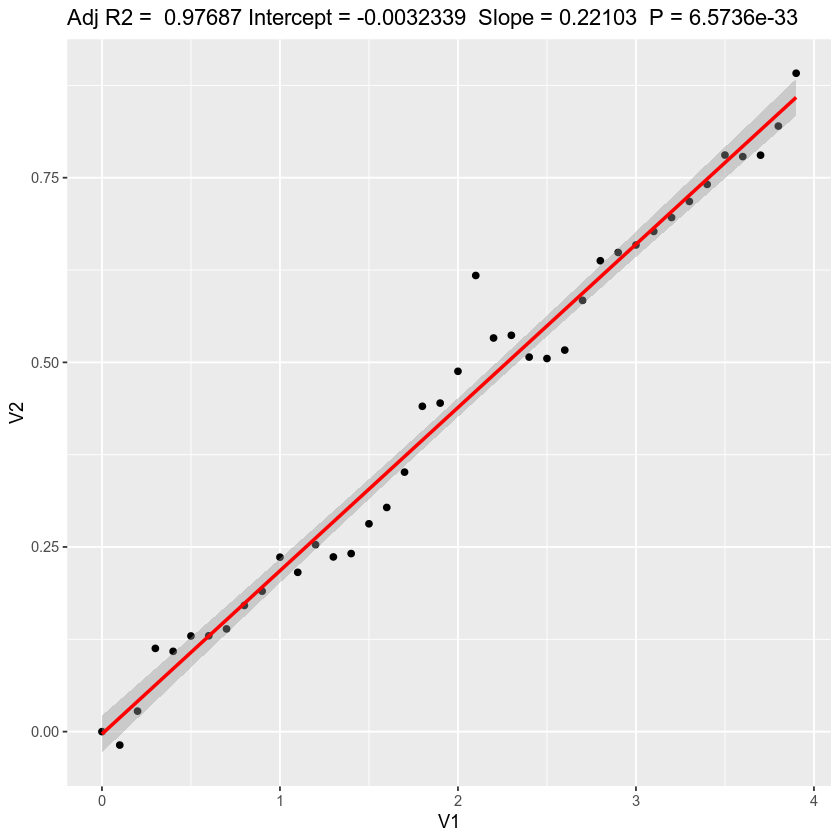

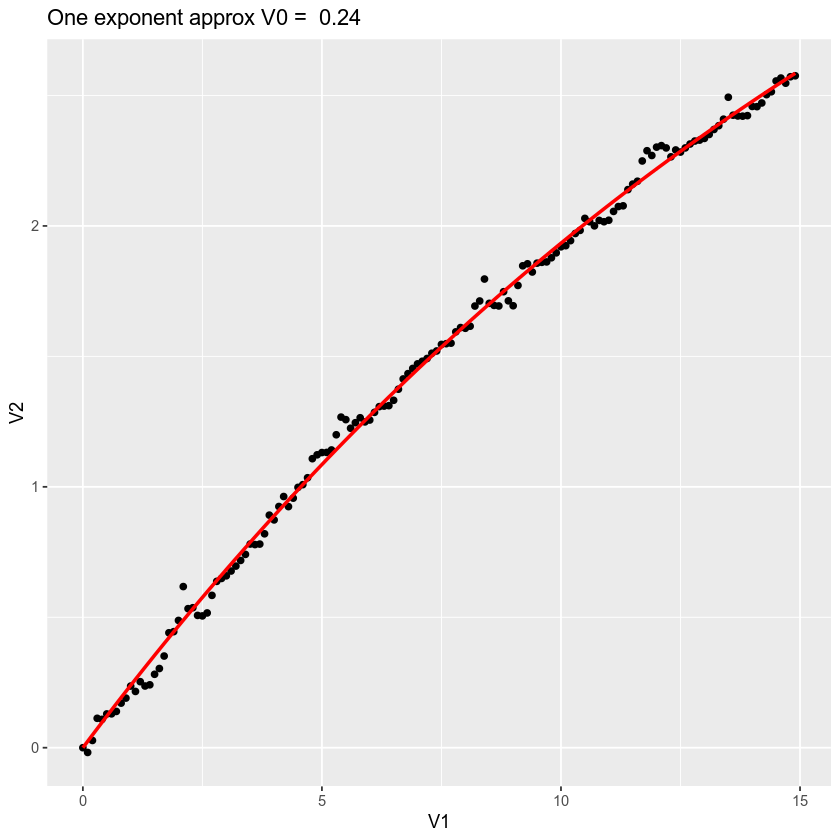

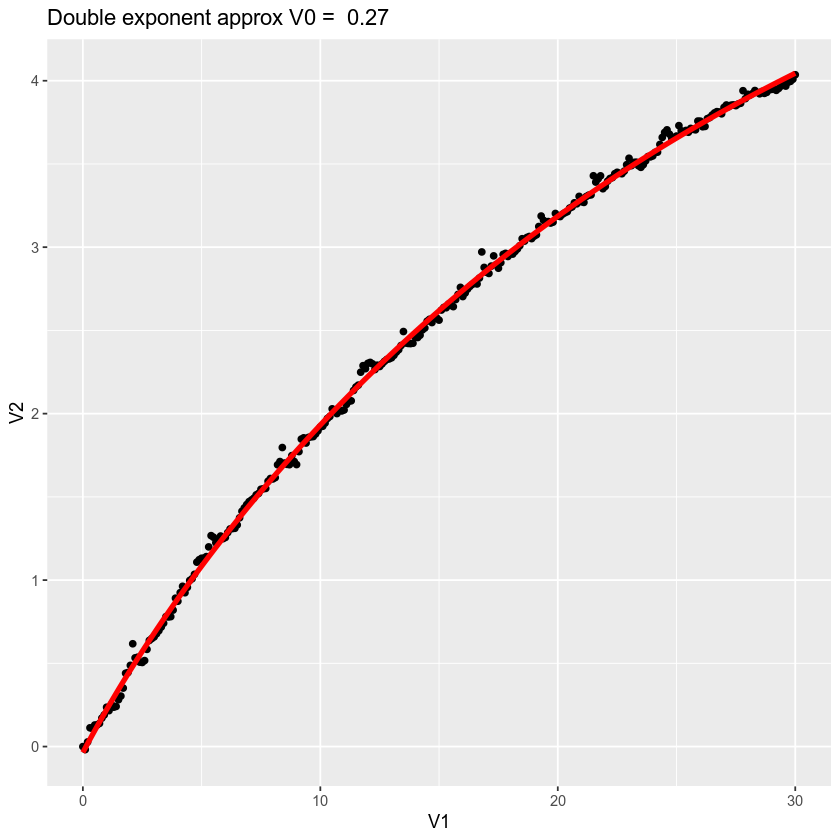

In [55]:
INDEX = 9

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 235
enzyme_start = 237
end_enzyme = 900

#Approximations
start_linear = 0
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 30
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T, IGNORE_NON_ENZ = TRUE)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
# out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)
out <- c(NA, NA, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 10 experimental point (10-air_tween0_1_hooh50mkM_tmpd5mkM_pghs10mkl)

No nonezymatic part found! Ignoring normalization.
SUBBORN ACTIVATED :)
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: singular convergence (7)”

NULL

NULL

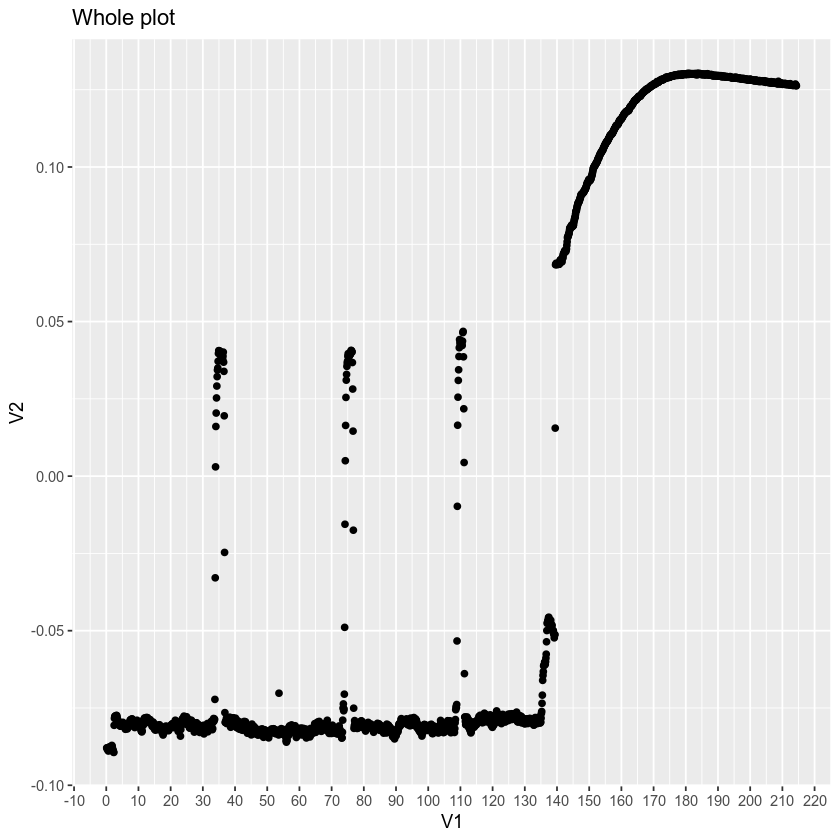

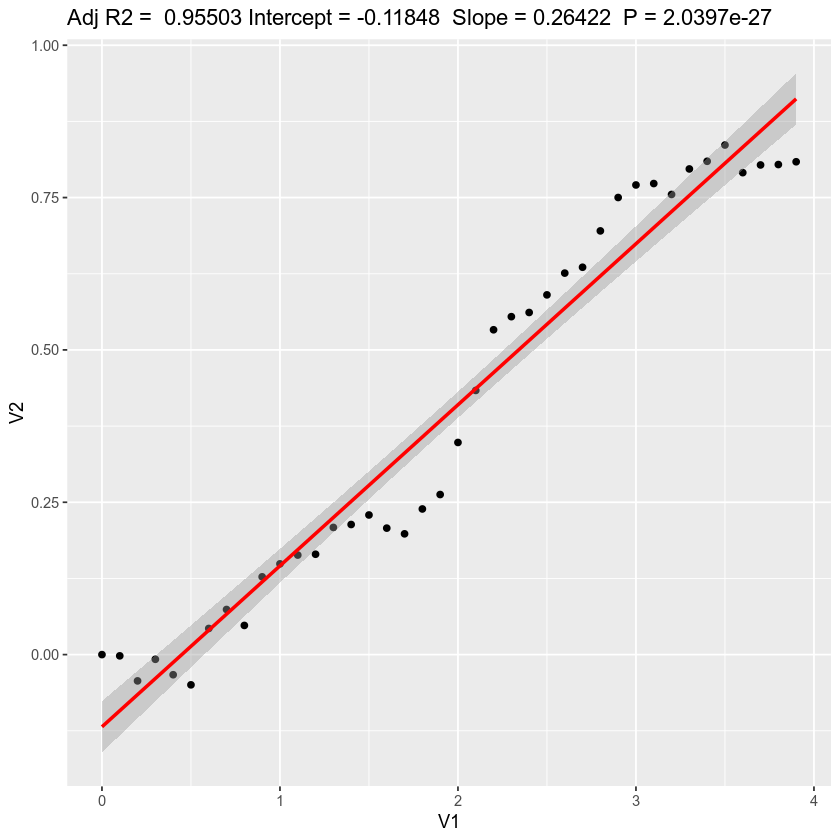

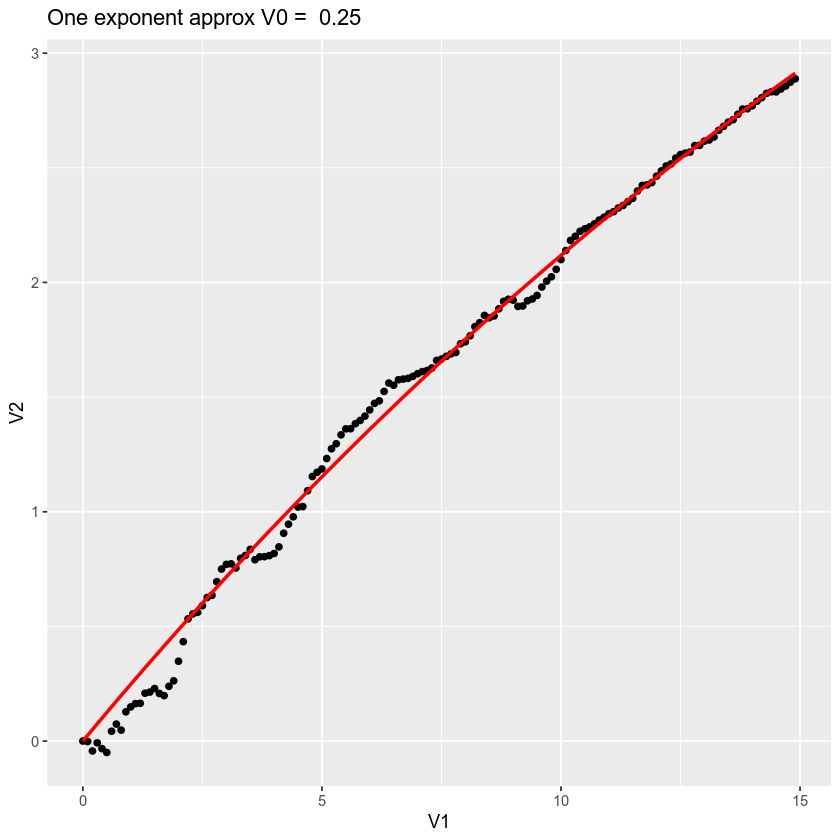

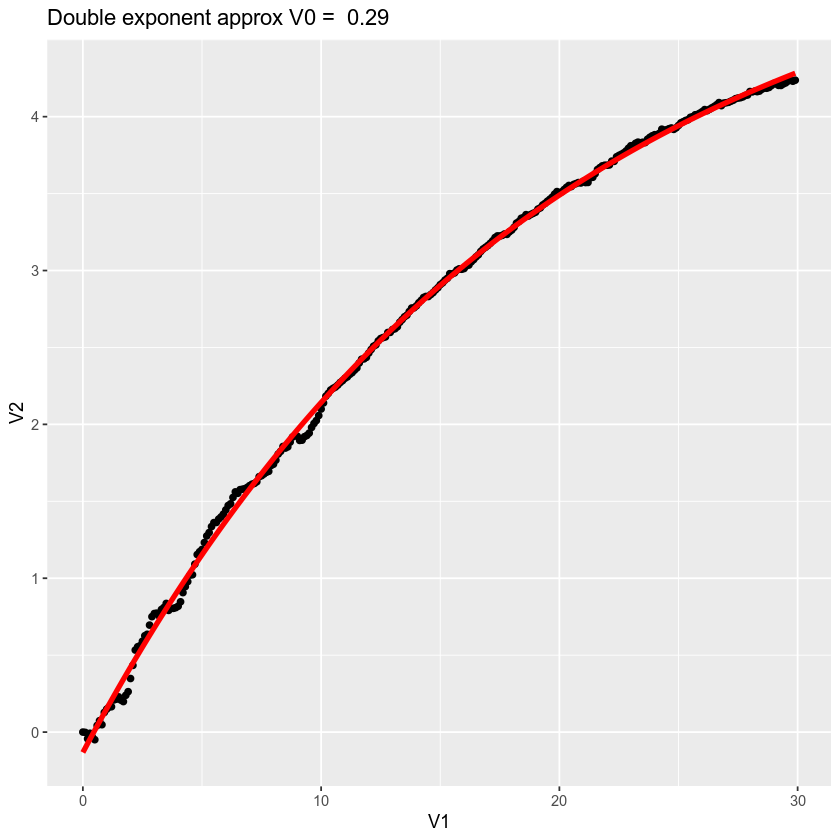

In [60]:
INDEX = 10

file_name = paste(c("pghs_data/", var_names[[INDEX]], ".csv"), collapse = "")
dot_data <- read.csv2(file_name)
colnames(dot_data) <- c("V1", "V2")

# =========================== RANGES ===================================
#The whole graph
linear_start = 100
enzyme_start = 140
end_enzyme = 900

#Approximations
start_linear = 1
end_linear = 4
start_exp = start_linear
end_exp = 15
end_double_exp = 30
# ======================================================================


dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN=T, IGNORE_NON_ENZ=T)
dot$whole_PLOT
# dot$support_PLOT
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
# dot$enzymatic_react_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(NA, NA, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

Poor convergence archieved for double exponent approximation since data is too close to a straight line. 
Using parameters from not converged approximation with least square distance from data.

In [62]:
write.csv(enz_curves, file = "All_enzyme_curves.csv", sep=",", row.names=FALSE)
write.csv(final_table, file = "final_params_table.csv", sep=",",row.names=FALSE, col.names=FALSE)

Warning message in write.csv(enz_curves, file = "All_enzyme_curves.csv", sep = ",", :
“attempt to set 'sep' ignored”Warning message in write.csv(final_table, file = "final_params_table.csv", sep = ",", :
“attempt to set 'col.names' ignored”Warning message in write.csv(final_table, file = "final_params_table.csv", sep = ",", :
“attempt to set 'sep' ignored”